In [4]:
expirement_tag = '5-08-Exp2'

intensity_filename = '../data/' + expirement_tag + '/intensityrel.mat'
location_filename = '../data/'+ expirement_tag + '/location.mat'

base_path = './pickle/' + expirement_tag + '_'
base_path_artifacts = './artifacts/' + expirement_tag + "_"

%matplotlib inline

In [2]:
#import base project to system path

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Load matlab data

In [5]:
import scipy.io
import numpy as np

intensity_matlab_file = scipy.io.loadmat(intensity_filename)

In [6]:
def plot_4_diffrent_response_curve(intensity_matlab_file, base_path_artifacts):
    import matplotlib
    import matplotlib.pyplot as plt

    def plot_intensity(ax, i):
        ax.plot(intensity_matlab_file['intensity'][i])
        ax.set_title('Cell ' + str(i))
        ax.set_xlabel('Time')
        ax.set_ylabel('Calcium Intensity')
    
    fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
    plot_intensity(axes[0, 0], 0)
    plot_intensity(axes[0, 1], 1)
    plot_intensity(axes[1, 0], 66)
    plot_intensity(axes[1, 1], 67)

    fig.suptitle('Cell Intensity')

    plt.subplots_adjust(hspace = 0.5)
    fig.savefig(base_path_artifacts + '4_diffrent_response_curve.png')
    plt.clf()
    plt.close(fig)

plot_4_diffrent_response_curve(intensity_matlab_file, base_path_artifacts)

### Preprocessing - Smooth Signals

In [7]:
from module.preprocessing import smooth

cells_intensity = smooth(intensity_matlab_file['intensity'])

print('The shape of the signal\'s data:' + str(cells_intensity.shape))

The shape of the signal's data:(674, 1022)


## Preprocssing - Numerically Differentiated the Response Curve

In [8]:
from module.preprocessing import first_derive_cells_intensity

normalized_cells_response_curve = first_derive_cells_intensity(cells_intensity)

### Mean Response Curve

In [9]:
def calc_mean_response_curve(cells_intensity):
    avg_intensity = np.zeros((cells_intensity.shape[1]))
    
    min_intensity = np.zeros((cells_intensity.shape[1])) + 1
    max_intensity = np.zeros((cells_intensity.shape[1])) - 1

    for cell_idx,cell_intensity in enumerate(cells_intensity):
        avg_intensity += cell_intensity
        #min_intensity = np.minimum(min_intensity, cell_intensity)
        #max_intensity = np.maximum(max_intensity, cell_intensity)    
    
    std_intensity = np.std(cells_intensity, axis=0)    
    avg_intensity = avg_intensity / cells_intensity.shape[0]
    
    return avg_intensity, std_intensity

mean_normalized_cells_response_curve, std_normalized_cells_response_curve = calc_mean_response_curve(normalized_cells_response_curve)

## Find Peaks Analysis

In [10]:
len(mean_normalized_cells_response_curve)

1017

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


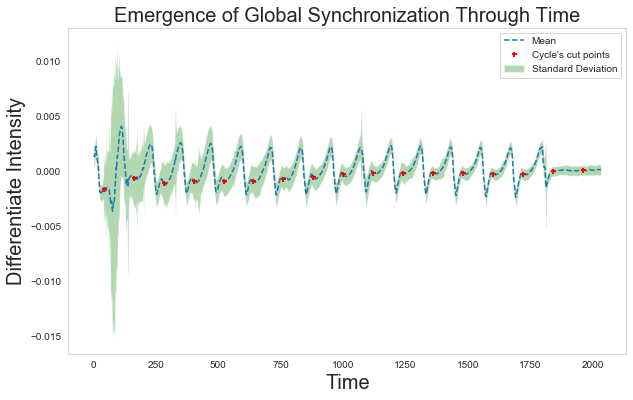

<Figure size 432x288 with 0 Axes>

In [11]:
def plot_peaks_analysis(indexes, mean_normalized_cells_response_curve, std_normalized_cells_response_curve, base_path):
    import matplotlib
    import matplotlib.pyplot as plt

    import peakutils
    from peakutils.plot import plot as pplot
    import seaborn as sns

    sns.set_style("whitegrid", {'axes.grid' : False, 'font_scale': 2})

    x = np.linspace(0, len(mean_normalized_cells_response_curve), len(mean_normalized_cells_response_curve))
    
    x = x * 2

    fig = plt.figure(figsize=(10,6))
    ax = pplot(x, mean_normalized_cells_response_curve, indexes)
    plt.fill_between(x, 
                     y1=mean_normalized_cells_response_curve - std_normalized_cells_response_curve, 
                     y2=mean_normalized_cells_response_curve + std_normalized_cells_response_curve, 
                     facecolor='Green', alpha=0.3)

    plt.legend(['Mean', 'Cycle\'s cut points', 'Standard Deviation'])

    plt.title('Emergence of Global Synchronization Through Time', fontsize=20)
    plt.xlabel('Time', fontsize=20)
    plt.ylabel('Differentiate Intensity', fontsize=20)
    plt.xlim = 0
    plt.ylim = [-0.03, 0.03]
    fig.savefig(base_path + 'peaks_analysis.png')
    fig.savefig(base_path + 'peaks_analysis.eps', format='eps')
    plt.show()
    plt.clf()
    plt.close(fig)

indexes = list(range(20, 1000, 60))

plot_peaks_analysis(indexes, mean_normalized_cells_response_curve, 

                    std_normalized_cells_response_curve, base_path_artifacts)

<Figure size 432x288 with 0 Axes>

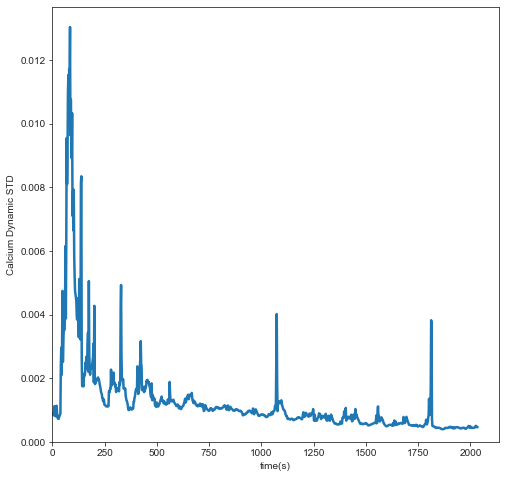

<Figure size 432x288 with 0 Axes>

In [16]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("ticks", {'axes.grid' : False, 'font_scale': 2, "xtick.major.size": 20, "ytick.major.size": 20})

fig = plt.figure(figsize=(8,8))

x = np.linspace(0, len(mean_normalized_cells_response_curve), len(mean_normalized_cells_response_curve))

x = x * 2

ax = sns.lineplot(y=std_normalized_cells_response_curve, x=x, palette="tab10", linewidth=2.5)

ax.set(xlabel="time(s)", ylabel="Calcium Dynamic STD")

ax.set(ylim=0)
ax.set(xlim=0)

plt.show()

fig.savefig(base_path_artifacts + '_calcium_dynamic_std' + '.eps', format='eps')
fig.savefig(base_path_artifacts + '_calcium_dynamic_std' + '.png')

plt.clf()
plt.close(fig)

## Divide the frames by the peaks

In [17]:
from module.helpers import divide_frames_by_indices

indexes_activation_time = list(range(30, 1000, 60))

cells_response_curve_parts = divide_frames_by_indices(indexes, normalized_cells_response_curve)
cells_response_curve_parts_activiation_time = divide_frames_by_indices(indexes_activation_time, cells_intensity)

activation_time_curve_parts = cells_response_curve_parts_activiation_time

### Analysis of Activation Time

In [18]:
from bisect import bisect_left

def find_activation(cells_intensity, threshold=0.10):
    intensity_activation_frame = np.zeros((cells_intensity.shape[0]))    
    for i in range(cells_intensity.shape[0]):
        min_value = np.min(cells_intensity[i])
        max_value = np.max(cells_intensity[i])
        cell_value_threshold = cells_intensity[i][0] + threshold*(max_value-min_value)
        
        activation_time_arrival = [idx for idx,value in enumerate(cells_intensity[i]) if abs(value)>abs(cell_value_threshold)]
        intensity_activation_frame[i] = activation_time_arrival[0] if len(activation_time_arrival) > 0 else len(activation_time_arrival)
        #print(str(min_value) + ' ' + str(max_value) + ' t: ' + str(cell_value_threshold) + ' i: ' + str(intensity_activation_frame[i]))
    
    return intensity_activation_frame

def calc_activation_time_for_parts(activation_time_curve_parts, number_of_parts):
    activation_time_scores = {}
    for part in range(0, number_of_parts):
        activation_time_scores[part] = find_activation(activation_time_curve_parts[part])
    
    return activation_time_scores

activation_time_feature_scores = calc_activation_time_for_parts(activation_time_curve_parts, len(activation_time_curve_parts))

### Validate that the time series is stationary

In [19]:
from module.stathelper import validate_stationary
#import warnings

warnings.filterwarnings("ignore")

p_value_results_adf, p_value_results_kpss  = validate_stationary(normalized_cells_response_curve)

NameError: name 'warnings' is not defined

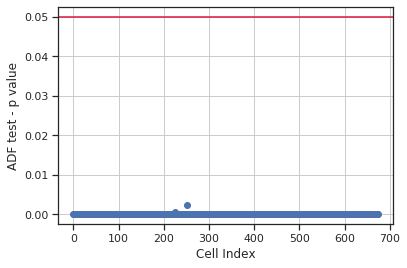

In [307]:
import matplotlib.pyplot as plt

plt.plot(p_value_results_adf, 'bo')

p_line = plt.axhline(0.05, color="crimson")

plt.xlabel('Cell Index')
plt.ylabel('ADF test - p value')
plt.grid(True)

plt.show()

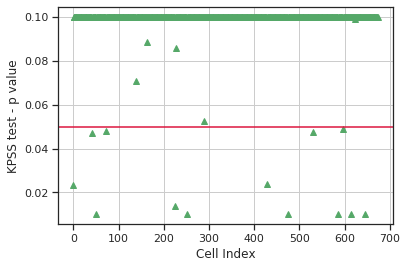

In [308]:
import matplotlib.pyplot as plt

plt.plot(p_value_results_kpss, 'g^')

p_line = plt.axhline(0.05, color="crimson")

plt.xlabel('Cell Index')
plt.ylabel('KPSS test - p value')
plt.grid(True)

plt.show()

### Filter out cells which have non-stationary response curve

In [309]:
kpss_filter = [True if p_value > 0.05 else False for p_value in p_value_results_kpss]
adf_filter = [True if p_value <= 0.05 else False for p_value in p_value_results_adf]

kpss_and_adf_filter = np.logical_and(kpss_filter, adf_filter)

np.sum(kpss_and_adf_filter) / float(len(kpss_and_adf_filter))

0.9807121661721068

## Voronoi diagram

### load centroids data

In [310]:
location_matlab_file = scipy.io.loadmat(location_filename)

centroids = location_matlab_file['centroids']

In [311]:
centroids

array([[  5.,  97.],
       [  6., 573.],
       [  7., 710.],
       ...,
       [950., 138.],
       [952., 269.],
       [955., 119.]])

In [312]:
from scipy.spatial import ConvexHull
from module.topologicalhelper import area_of_rectangle, bounding_box
from module.topologicalhelper import split_to_small_bounding_boxes, filter_edges_in_bb_by_td, in_rect

hull = ConvexHull(centroids)

#print(hull.area)
rect_vert = bounding_box(centroids[hull.vertices])
#print(rect_vert)

#print(split_to_small_bounding_boxes(2, rect_vert))

print(centroids.shape[0])
area = area_of_rectangle(rect_vert[1][0]-rect_vert[0][0], rect_vert[2][1]-rect_vert[1][1])
area = area/(1000**2 * (0.656**2)) #convert to mm
print(1/area)
print(centroids.shape[0]*(1/(area)))

674
The Area of the Rectangle is 674500.0
0.6380074128984433
430.0169962935508


In [313]:
from scipy.spatial import Voronoi, voronoi_plot_2d
from module.topologicalhelper import voronoi_finite_polygons_2d

vor = Voronoi(centroids)

regions, vertices = voronoi_finite_polygons_2d(vor)

def plot_voronoi(regions, vertices, vor, points):
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    for region in regions:
        polygon = vertices[region]
        ax.fill(*zip(*polygon), alpha=0.7)
    
    ax.plot(points[:,0], points[:,1], 'ko')
    ax.set_xlim(vor.min_bound[0] - 0.1, vor.max_bound[0] + 0.1)
    ax.set_ylim(vor.min_bound[1] - 0.1, vor.max_bound[1] + 0.1)
    
    #plt.savefig("voronoi.png", dpi=800)
    plt.show()

In [314]:
plot_voronoi(regions, vertices, vor, centroids)

## Delaunay triangulation

In [315]:
from scipy.spatial import Delaunay
from module.topologicalhelper import find_neighbors

tri = Delaunay(centroids)

In [316]:
neighbor_indices = find_neighbors(tri, centroids)
#neighbor_indices[0]

## Serialization Stuff

In [317]:
from module.serializationhelper import save_object, load_object

In [318]:
analyze_result_df = load_object(base_path + 'analyze_result_df')

analyze_cell_stats = load_object(base_path + 'analyze_cell_stats')

## Analyze GC

In [29]:
from modulev2.analyzetools import analyze_network

if analyze_result_df is None:
    analyze_result_df = analyze_network(neighbor_indices, cells_response_curve_parts, kpss_and_adf_filter, 2)
    
    analyze_result_df['total_neighbours'] = analyze_result_df.groupby(['source', 'part'])['destination'].transform(lambda x: x.count())
    analyze_result_df['critical_value'] = 0.05 / analyze_result_df['total_neighbours']
    analyze_result_df['significant'] = analyze_result_df['granger_causality_pvalue'] < analyze_result_df['critical_value']
    analyze_result_df['significant'] = analyze_result_df['significant'].astype(int)
    
    save_object(analyze_result_df, base_path + 'analyze_result_df')

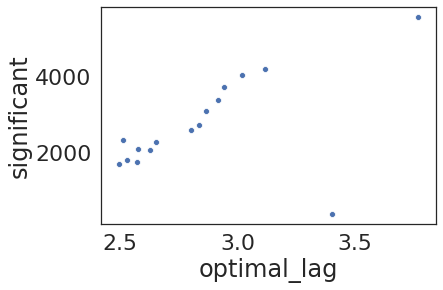

In [63]:
sns.scatterplot(x=analyze_result_df.groupby(['part']).mean().optimal_lag, y=analyze_result_df.groupby(['part']).sum().significant)

In [42]:
import pandas as pd
import scipy.stats as stats

analyze_cell_stats_gc_out = analyze_result_df.groupby(['source', 'part']).agg('mean').unstack().loc[:, ['significant']].rename(columns={'significant':'gc_out'})
analyze_cell_stats_gc_in = analyze_result_df.groupby(['destination', 'part']).agg('mean').unstack().loc[:, ['significant']].rename(columns={'significant':'gc_in'})
analyze_cell_stats = pd.concat([analyze_cell_stats_gc_in, analyze_cell_stats_gc_out], axis=1, sort=False)
#analyze_cell_stats = analyze_cell_stats.fillna(0)
tr_rec_corr = pd.DataFrame(columns=['cycle', 'corr', 'p_value'])

for cycle in range(0, 13):
    tr_rec_corr = tr_rec_corr.append({'cycle': cycle,
                                      'corr': stats.pearsonr(analyze_cell_stats[('gc_in',cycle)], analyze_cell_stats[('gc_out',cycle)])[0],
                                      'p_value': stats.pearsonr(analyze_cell_stats[('gc_in',cycle)], analyze_cell_stats[('gc_out',cycle)])[1]},
                                     ignore_index=True)
tr_rec_corr

cycle      corr       p_value
0     0.0  0.350112  1.700789e-20
1     1.0  0.302209  1.997584e-15
2     2.0  0.239153  4.737508e-10
3     3.0  0.191850  6.717544e-07
4     4.0  0.182960  2.190592e-06
5     5.0  0.302384  1.921515e-15
6     6.0  0.210406  4.747027e-08
7     7.0  0.275393  5.730064e-13
8     8.0  0.211083  4.289757e-08
9     9.0  0.192519  6.132150e-07
10   10.0  0.127612  1.008504e-03
11   11.0  0.170090  1.098633e-05
12   12.0  0.099001  1.087309e-02

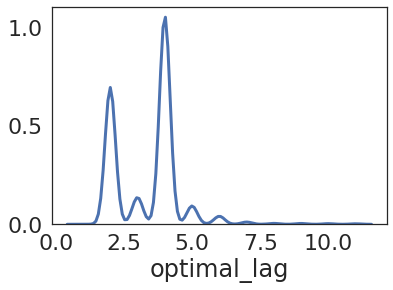

In [53]:
sns.distplot(analyze_result_df[analyze_result_df.part == 15.0].optimal_lag, hist=False)

In [145]:
np.exp(-1.555034)

0.21118220232402743

In [146]:
np.exp(-0.032793)

0.9677388608013272

In [144]:
analyze_result_df

source  destination  part  topological_distance  optimal_lag  \
0         1.0          2.0   0.0                   1.0          2.0   
1         1.0          3.0   0.0                   1.0          2.0   
2         1.0         36.0   0.0                   1.0          6.0   
3         1.0          6.0   0.0                   1.0          2.0   
4         1.0         39.0   0.0                   1.0          4.0   
...       ...          ...   ...                   ...          ...   
12269   673.0        651.0  15.0                   2.0          2.0   
12270   673.0        654.0  15.0                   2.0          3.0   
12271   673.0        656.0  15.0                   2.0          2.0   
12272   673.0        663.0  15.0                   2.0          4.0   
12273   673.0        668.0  15.0                   2.0          4.0   

       granger_causality_mag  granger_causality_pvalue  total_neighbours  \
0                  -0.270397              7.727845e-04              36.0   
1                  -0.032793              4.193681e-01              36.0   
2                  -1.555034              2.207141e-12              36.0   
3                  -0.191482              6.255608e-03              36.0   
4                  -0.887405              1.300743e-08              36.0   
...                      ...                       ...               ...   
12269              -0.161323              1.391128e-02              23.0   
12270              -0.082352              2.448839e-01              23.0   
12271              -0.003647              9.078754e-01              23.0   
12272              -0.187436              6.129889e-02              23.0   
12273              -0.184558              6.485325e-02              23.0   

       critical_value  significant  
0            0.001389            1  
1            0.001389            0  
2            0.001389            1  
3            0.001389            0  
4            0.001389            1  
...               ...          ...  
12269        0.002174            0  
12270        0.002174            0  
12271        0.002174            0  
12272        0.002174            0  
12273        0.002174            0  

[196384 rows x 10 columns]

In [165]:
sns.scatterplot(1-np.exp(analyze_result_df['granger_causality_mag']), analyze_result_df['granger_causality_pvalue'])

## The correlation between the GC magnitude and P-value

In [166]:
stats.pearsonr(1-np.exp(analyze_result_df['granger_causality_mag']), analyze_result_df['granger_causality_pvalue'])

(-0.5913791469531973, 0.0)

## Figure 3C - This trend of improved synchronization coincided with a gradual increase of the overall information-flow, measured via the mean cells’ edge probability

In [31]:
def divide_frames_by_indices_single_dim(indices, cells_response_curve):
    cells_response_curve_parts = []

    for i in range(0, len(indices) - 1):
        cells_response_curve_parts.append(cells_response_curve[indices[i]:indices[i+1]])
    
    return cells_response_curve_parts

std_normalized_cells_response_curve_parts = divide_frames_by_indices_single_dim(indexes, std_normalized_cells_response_curve)

In [32]:
def plot_scatter_mbar_color(x, y, x_feature_name, y_feature_name, prefix='', 
                            save=False, xlim=None, ylim=None, xlog=False, ylog=False, color_set='Set1', hue=None, hue_name=''):
    import scipy.stats as stats

    sns.set(style='white', font_scale = 2, rc={"lines.linewidth": 3})
    
    df = pd.DataFrame(index=hue, columns=[hue_name, x_feature_name, y_feature_name])
    df[x_feature_name] = x
    df[y_feature_name] = y
    df[hue_name] = hue
    
    if xlog:
        x = np.log(x)
        df['log('+x_feature_name+')'] = np.log(df[x_feature_name])
        x_feature_name = 'log('+x_feature_name+')'
    
    if ylog:
        y = np.log(y)
        df['log('+y_feature_name+')'] = np.log(df[x_feature_name])
        y_feature_name = 'log('+y_feature_name+')'
        
    from matplotlib.colors import ListedColormap
    
    my_color_bar = ListedColormap(sns.color_palette(color_set, len(hue)))

    fig, ax = plt.subplots(figsize=(12,6))
    ax = sns.scatterplot(ax=ax, data=df, x=x_feature_name, y=y_feature_name, hue=hue_name, s=100, palette=my_color_bar)
    
    
    
    if (ylim is not None):
        ax.set(ylim=ylim)
    
    if (xlim is not None):
        ax.set(xlim=xlim)

    ax.set(xlabel=x_feature_name, ylabel=y_feature_name)

    data_correlation = stats.pearsonr(x=x, y=y)

    ax.annotate("n={}, coefficient = {:.4f}, p = {:.4f}".format(len(x),
                data_correlation[0], data_correlation[1]), 
                xy=(.1, .2), xycoords=ax.transAxes, fontsize=11)
    
    #plt.legend(loc="upper left", ncol=len(df.columns), prop={"size":15})
    ax.legend_.remove()
    
    import matplotlib
    
    plt.colorbar(mpl.cm.ScalarMappable(cmap=my_color_bar, norm=matplotlib.colors.Normalize(vmin=0, vmax=11)))
    
    #fig.colorbar(mpl.cm.ScalarMappable(cmap=my_color_bar),
    #         cax=ax, orientation='horizontal', label='Cycles')

    #plt.plot(ticks_range, ticks_range, 'r--')

    plt.tight_layout(pad=0.4, w_pad=2, h_pad=1.0)

    plt.show()
    
    if save:
        fig.savefig(base_path_artifacts + '_' + prefix + '_' + x_feature_name + '_vs_' + y_feature_name + '.eps', format='eps')
        fig.savefig(base_path_artifacts + '_' + prefix + '_' + x_feature_name + '_vs_' + y_feature_name + '.png')
    plt.clf()
    plt.close(fig)

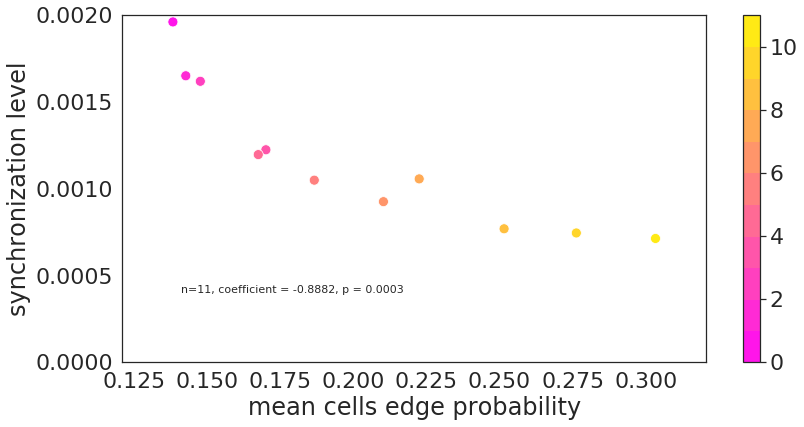

<Figure size 432x288 with 0 Axes>

In [34]:
import seaborn as sns
import pandas as pd
import matplotlib as mpl

plot_scatter_mbar_color(x=np.array(analyze_result_df.groupby(['part'])['significant'].sum()/analyze_result_df.groupby(['part'])['significant'].count())[1:12],
                       y=np.mean(std_normalized_cells_response_curve_parts, axis=1)[1:12],
                       x_feature_name='mean cells edge probability',
                       y_feature_name='synchronization level',
                       save=True, 
                       hue=(analyze_result_df.groupby(['part'])['significant'].sum()/analyze_result_df.groupby(['part'])['significant'].count()).index[1:12],
                       hue_name='Cycle',
                       ylim=[0, 0.002],
                       color_set='spring')

### Association between # neighbors and Transmission/Receiver 

In [31]:
from scipy.stats import pearsonr
import seaborn as sns

def corrfunc(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    rho = '\u03C1'
    ax.annotate(f'{rho} = {r:.2f}', xy=(.01, .9), xycoords=ax.transAxes)
'''
def plot_association_between_neighbors_transmission(analyze_result_df, base_path_artifacts):    
    sns.set_style("whitegrid", {'axes.grid' : False, 'font_scale': 2})

    g = sns.pairplot(analyze_result_df.groupby(['source', 'part']) \
    .agg('mean').unstack().loc[:, ['significant','total_neighbours']] \
    .rename(columns={'significant':'Transmission Score'}))
    g.map_lower(corrfunc)
    g.fig.savefig(base_path_artifacts + 'association_between_neighbors_transmission.png')
    plt.clf()
    plt.close(g.fig)

def plot_association_between_neighbors_receiver(analyze_result_df, base_path_artifacts):
    sns.set_style("whitegrid", {'axes.grid' : False, 'font_scale': 2})

    g = sns.pairplot(analyze_result_df.groupby(['destination', 'part']) \
    .agg('mean').unstack().loc[:, ['significant','total_neighbours']] \
    .rename(columns={'significant':'Receiver Score'}).loc[:, (slice(None), 0)])
    g.map_lower(corrfunc)
    g.fig.savefig(base_path_artifacts + 'association_between_neighbors_receiver.png')
    plt.clf()
    plt.close(g.fig)

plot_association_between_neighbors_transmission(analyze_result_df, base_path_artifacts)
plot_association_between_neighbors_receiver(analyze_result_df, base_path_artifacts)
'''

'\ndef plot_association_between_neighbors_transmission(analyze_result_df, base_path_artifacts):    \n    sns.set_style("whitegrid", {\'axes.grid\' : False, \'font_scale\': 2})\n\n    g = sns.pairplot(analyze_result_df.groupby([\'source\', \'part\'])     .agg(\'mean\').unstack().loc[:, [\'significant\',\'total_neighbours\']]     .rename(columns={\'significant\':\'Transmission Score\'}))\n    g.map_lower(corrfunc)\n    g.fig.savefig(base_path_artifacts + \'association_between_neighbors_transmission.png\')\n    plt.clf()\n    plt.close(g.fig)\n\ndef plot_association_between_neighbors_receiver(analyze_result_df, base_path_artifacts):\n    sns.set_style("whitegrid", {\'axes.grid\' : False, \'font_scale\': 2})\n\n    g = sns.pairplot(analyze_result_df.groupby([\'destination\', \'part\'])     .agg(\'mean\').unstack().loc[:, [\'significant\',\'total_neighbours\']]     .rename(columns={\'significant\':\'Receiver Score\'}).loc[:, (slice(None), 0)])\n    g.map_lower(corrfunc)\n    g.fig.savefig(b

In [48]:
import pandas as pd

from bisect import bisect_left

def find_activation(cells_intensity, threshold):
    from scipy.signal import find_peaks
    violations = 0
    
    intensity_activation_frame = np.zeros((cells_intensity.shape[0]))
    for i in range(cells_intensity.shape[0]):
        min_value = np.min(cells_intensity[i])
        max_value = np.max(cells_intensity[i])
        cell_value_threshold = cells_intensity[i][0] + threshold*(max_value-cells_intensity[i][0])
        
        activation_time_arrival = [idx for idx,value in enumerate(cells_intensity[i]) if value>cell_value_threshold]
        
        if len(activation_time_arrival) < 1:
            violations += 1
            intensity_activation_frame[i] = 0
        else:
            intensity_activation_frame[i] = activation_time_arrival[0]
            
    return intensity_activation_frame, violations

def find_activation_by_peak(cells_intensity, threshold=0.10):
    from scipy.signal import find_peaks
    violations = 0
    intensity_activation_frame = np.zeros((cells_intensity.shape[0]))    
    for i in range(cells_intensity.shape[0]):
        #min_value = np.min(cells_intensity[i])
        #max_value = np.max(cells_intensity[i])
        #cell_value_threshold = min_value + threshold*(max_value-min_value)
        
        activation_time_arrival = find_peaks(cells_intensity[i])[0]
        if len(activation_time_arrival) < 1:
            violations += 1
            intensity_activation_frame[i] = len(cells_intensity[i]) - 1
        else:
            intensity_activation_frame[i] = activation_time_arrival[0]
        
    
    print(violations)
    
    return intensity_activation_frame

def calc_activation_time_for_parts(activation_time_curve_parts, number_of_parts, threshold):
    violations = {}
    activation_time_scores = {}
    for part in range(0, number_of_parts):
        activation_time_scores[part], violations[part] = find_activation(activation_time_curve_parts[part], threshold=threshold)
    
    print(violations)
    
    return activation_time_scores

def perm_test_feature_cycles(analyze_cell_stats,
                             kpss_and_adf_filter,
                             score_funcs_dict):
    
    number_of_parts = len(analyze_cell_stats.columns.levels[1])
    
    #minus one since it compare part i with part i+1
    perm_test = pd.DataFrame(columns=range(0, number_of_parts))
    cc_score = pd.DataFrame(columns=range(0, number_of_parts))
    
    for score_name, score_funcs in score_funcs_dict.items():        
        score_for_parts_x = score_funcs[0](analyze_cell_stats)
        score_for_parts_y = score_funcs[1](analyze_cell_stats)

        perm_test_leader_scores = {}
        parts_cc_scores = {}

        for part in range(0, number_of_parts):
            xs = score_for_parts_x[part]
            ys = score_for_parts_y[part]        

            xs = apply_custom_filter(xs, kpss_and_adf_filter)
            ys = apply_custom_filter(ys, kpss_and_adf_filter)

            perm_test_leader_scores[part] = exact_mc_perm_test(xs, ys, pearsonr, 1000, None)     

            parts_cc_scores[part] = pearsonr(xs, ys)[0]

        perm_test.loc[score_name] = perm_test_leader_scores
        cc_score.loc[score_name] = parts_cc_scores
    
    return perm_test, cc_score

In [46]:
def plot_cell_maintain_memory_of_communication_functional_activation_time(base_path_artifacts, analyze_cell_stats, threshold):
    from plots_analyzetools import color_not_significant_red
    
    steps_df = None
    sample_df = None
    
    for step_corr in range(1, 2, 1):            
        gc_sign_perm_test, gc_sign_cc_score = perm_test_seq_cycles(analyze_cell_stats, None, #already filtered
                                                               {'activation_time': activation_time_score_func},
                                                                step_corr)

        fig, ax = plt.subplots(figsize=(20,6))
        sns.heatmap(gc_sign_perm_test, annot=True, linewidths=.2, cmap = sns.cm.rocket_r)
        fig.savefig(base_path_artifacts + 'activation_time_' + 'threshold_' + str(threshold) + '_cell_maintain_memory_of_communication_functional_perm_test_' + str(step_corr) + '.png')
        fig.savefig(base_path_artifacts + 'activation_time_' + 'threshold_' + str(threshold) + '_cell_maintain_memory_of_communication_functional_perm_test_' + str(step_corr) + '.eps', format='eps')
        plt.show()
        plt.clf()
        plt.close(fig)

        #prepeare data strcuture 
        gc_sign_cc_score_tranpose = gc_sign_cc_score.transpose()[:12][['activation_time']].stack().to_frame(name='vals')
        gc_sign_cc_score_tranpose['Functional'] = gc_sign_cc_score_tranpose.index.get_level_values(1) + ' s:' + str(step_corr) 
        
        if steps_df is None:
            steps_df = gc_sign_cc_score_tranpose
        else:
            steps_df = pd.concat([steps_df, gc_sign_cc_score_tranpose])
        
        # calculate sample cell organization
        sample_cc_score = sample_perm_seq_cycles(analyze_cell_stats,
                                {'activation_time': activation_time_score_func},
                                  step_corr)
        
        #prepare sample data strcuture
        sample_cc_score_tranpose = sample_cc_score.transpose()[:12][['activation_time']].rename(columns={'activation_time':'Sample activation_time'}).stack().to_frame(name='vals')
        sample_cc_score_tranpose['Functional'] = sample_cc_score_tranpose.index.get_level_values(1) + ' s:' + str(step_corr) 
        
        if sample_df is None:
            sample_df = sample_cc_score_tranpose
        else:
            sample_df = pd.concat([sample_df, sample_cc_score_tranpose])
    
    
    
    sns.set(style='white', font_scale = 2, rc={"lines.linewidth": 3})
    #sns.set_palette("terrain")

    fig, ax = plt.subplots(figsize=(24,12))
    
    sns.pointplot(ax=ax, y='vals', x=steps_df.index.get_level_values(0), data=steps_df, hue='Functional', legend=True)
    sns.pointplot(ax=ax, y='vals', x=sample_df.index.get_level_values(0), data=sample_df, hue='Functional', legend=True, linestyles=["--", "--"])
    #ax.text(7, 0.1,'P-value=[0, 0.019]', fontsize=20) #add text
    ax.set(xticks=range(0, 12))
    ax.set_xlim([0, 11])
    ax.set_ylim(-0.15, 0.15)
    #ax.set(xlabel='correlation between cycles', ylabel='level')
    ax.set_title('activation_time threshold: ' + str(threshold))
    
    fig.savefig(base_path_artifacts + 'activation_time_' + 'threshold_' + str(threshold) + '_memory' + str(step_corr) + '.png')
    fig.savefig(base_path_artifacts + 'activation_time_' + 'threshold_' + str(threshold) + '_memory' + str(step_corr) + '.eps', format='eps')
    plt.show()
    plt.clf()
    plt.close(fig)

In [47]:
def plot_activation_time(threshold):
    #analyze activation time
    analyze_cell_stats = None
    
    analyze_cell_stats_gc_out = analyze_result_df.groupby(['source', 'part']).agg('mean').unstack().loc[:, ['significant']].rename(columns={'significant':'gc_out'})
    analyze_cell_stats_gc_in = analyze_result_df.groupby(['destination', 'part']).agg('mean').unstack().loc[:, ['significant']].rename(columns={'significant':'gc_in'})
    analyze_cell_stats = pd.concat([analyze_cell_stats_gc_in, analyze_cell_stats_gc_out], axis=1, sort=False)
    analyze_cell_stats = analyze_cell_stats.fillna(0)

    activation_time_feature_scores = calc_activation_time_for_parts(activation_time_curve_parts, len(cells_response_curve_parts), threshold)

    for part in activation_time_feature_scores:
        analyze_cell_stats['activation_time', part] = apply_custom_filter(activation_time_feature_scores[part], kpss_and_adf_filter)
    
    gc_sign_perm_test, gc_sign_cc_score = perm_test_seq_cycles(analyze_cell_stats, None, 
                                                               {'gc_out' : gc_out_score_func,
                                                                'gc_in': gc_in_score_func,                                                
                                                                'activation_time': activation_time_score_func}, step=1)
    gc_sign_cc_score

    activation_frame_gc_sign_perm_test, activation_frame_gc_sign_cc_score = perm_test_feature_cycles(analyze_cell_stats, None, 
                                                                            {'gc_out vs activation_time' : [gc_out_score_func, activation_time_score_func],
                                                                             'gc_in vs activation_time': [gc_in_score_func, activation_time_score_func],                                                                         
                                                                             'gc_out vs gc_in': [gc_out_score_func, gc_in_score_func]})

    fig, ax = plt.subplots(figsize=(24,12))

    sns.pointplot(ax=ax, data=activation_frame_gc_sign_cc_score.loc[['gc_out vs activation_time'], :12], color="#007CFF")
    sns.pointplot(ax=ax, data=activation_frame_gc_sign_cc_score.loc[['gc_in vs activation_time'], :12], color="#FF0000")
    #ax.text(7, 0.1,'P-value=[0, 0.019]', fontsize=20) #add text
    ax.set(xticks=range(0, 13))
    ax.set_xlim([0, 12])
    ax.set_ylim([-0.15, 0.15])
    #ax.set(xlabel='correlation between cycles', ylabel='level')
    ax.set_title('Activation Time ' + str(threshold) + ' vs Communication')
    leg = ax.legend(['Transmission Score vs Activation Time', 'Receiver Score vs Activation Time'])
    leg.legendHandles[0].set_color("#007CFF")
    leg.legendHandles[1].set_color("#FF0000")

    fig.savefig(base_path_artifacts + 'activation_time_vs_communication_' + str(threshold) +'.png')
    fig.savefig(base_path_artifacts + 'activation_time_vs_communication_' + str(threshold) + '.eps', format='eps')
    plt.show()
    plt.clf()
    plt.close(fig)

    #plot_memory_extent_over_time(base_path_artifacts, analyze_cell_stats)
    plot_cell_maintain_memory_of_communication_functional_activation_time(base_path_artifacts, analyze_cell_stats, threshold)


for i in range(10, 35):
    plot_activation_time(float(i)/100.0)

[ 0.37425727  0.35624878  0.34158478  0.32943623  0.31750823  0.30543338
  0.29421204  0.28354381  0.27231603  0.26132177  0.25331468  0.25018241
  0.24690726  0.24009807  0.23039231  0.23500123  0.23817581  0.22923057
  0.22004759  0.21090916  0.20609273  0.19649569  0.17215666  0.14861967
  0.12588626  0.10414797  0.08361608  0.06425349  0.04590339  0.02865254
  0.01718035  0.00965967  0.00129101 -0.00658685 -0.01370092 -0.01642992
 -0.01590343 -0.0145858  -0.01201886 -0.00810251 -0.00344509  0.00193915
  0.00844287  0.01605439  0.02381269  0.0314189   0.03933142  0.04708044
  0.0654587   0.08793161  0.10832897  0.12968969  0.15072738  0.17875782
  0.20400888  0.22914539  0.25434458  0.27876482  0.29632011  0.30368116]
0.37425726523116476
0.37425726523116476
0.1
[ 0.00313899  0.00184596  0.00117528  0.00087764  0.00068005  0.00040211
 -0.0004005  -0.00213575 -0.00456474 -0.00729338 -0.00978127 -0.01115427
 -0.01179162 -0.01212759 -0.0121004  -0.01158646 -0.01072493 -0.01025662
 -0.01

0.012454242956653296
0.1
[0.05568759 0.0549203  0.05415583 0.05330323 0.05245945 0.05176737
 0.05130803 0.05101441 0.05078443 0.05082548 0.05108943 0.05122803
 0.05107244 0.05078859 0.05053247 0.05021847 0.0497217  0.04906227
 0.04800439 0.04644062 0.04409412 0.04087123 0.03705563 0.03305566
 0.02892682 0.02472765 0.02062745 0.01672749 0.01282927 0.00885621
 0.00528046 0.00263504 0.00101142 0.00038696 0.0008531  0.00241941
 0.00546704 0.00914194 0.01264945 0.01570483 0.01798615 0.01951511
 0.02028174 0.0200496  0.01906693 0.01778728 0.01641933 0.01544734
 0.01510951 0.01533564 0.01617517 0.0173626  0.01875126 0.02003468
 0.02104997 0.02204413 0.02291977 0.02326371 0.02303444 0.02224159]
0.05568758678724205
0.05568758678724205
0.1
[0.07405742 0.07057112 0.06711821 0.06367271 0.06026109 0.05739247
 0.0554286  0.05393661 0.05257347 0.05157993 0.05118624 0.05086598
 0.05012176 0.04908336 0.048104   0.04727793 0.04659398 0.04619286
 0.04604068 0.0459     0.04555045 0.04451764 0.04265879 0.0

0.1
[0.12926048 0.12875037 0.1281163  0.12735712 0.12670815 0.12603958
 0.12533888 0.12489639 0.12506102 0.12565979 0.1263662  0.12703298
 0.12765945 0.12804106 0.12816969 0.12825924 0.1282128  0.12746187
 0.12622797 0.12470613 0.12245386 0.11922135 0.11527679 0.11099457
 0.10663491 0.10201456 0.09696718 0.09172434 0.08669246 0.08232214
 0.07900517 0.07694918 0.07628731 0.07766066 0.08085808 0.08534282
 0.09040415 0.09524177 0.09954478 0.10299989 0.10542351 0.10698192
 0.1078814  0.10829168 0.10817953 0.10743062 0.10647496 0.10565536
 0.10492828 0.1043718  0.10418213 0.10440733 0.10492277 0.10541449
 0.10582054 0.10619397 0.10656701 0.10701156 0.10761079 0.10820398]
0.12926048211037924
0.12926048211037924
0.1
[0.09234604 0.09146509 0.09040976 0.08949885 0.08871522 0.08818515
 0.0882413  0.08862393 0.08881571 0.08866248 0.08826522 0.0876671
 0.08663549 0.08529459 0.08411942 0.08291247 0.08161059 0.08015614
 0.07818918 0.0754786  0.07187904 0.06759557 0.06282765 0.05781268
 0.05297665 0.

[0.237045   0.23391123 0.23049406 0.22731688 0.22478649 0.22289377
 0.22166572 0.22113577 0.22098931 0.22026938 0.21880022 0.21649167
 0.21348165 0.21015922 0.20685324 0.20367785 0.20053277 0.19755602
 0.19446264 0.1909794  0.18716051 0.18311642 0.17872792 0.17398636
 0.16875541 0.16318324 0.1575482  0.15222431 0.14722918 0.14258856
 0.13851997 0.13533943 0.13278916 0.13177685 0.13398924 0.13679106
 0.14002102 0.14380655 0.14808966 0.1518333  0.15432381 0.15604301
 0.15720707 0.15816932 0.15936539 0.16084884 0.16251618 0.16406198
 0.16509636 0.16556138 0.1652064  0.16361838 0.1610469  0.15846286
 0.15647186 0.15485671 0.15337562 0.15274766 0.1535011  0.15512235]
0.237045000769981
0.237045000769981
0.1
[-0.02839137 -0.02902869 -0.03006523 -0.03135169 -0.03252807 -0.03298112
 -0.03291702 -0.03305275 -0.03351961 -0.03381454 -0.03370992 -0.03383701
 -0.03402833 -0.03410672 -0.03429111 -0.03553923 -0.03802819 -0.04031432
 -0.04250391 -0.04522115 -0.04823596 -0.05123281 -0.0548115  -0.059259

[0.29274219 0.29127957 0.28986746 0.28838015 0.28684668 0.28577933
 0.28543524 0.28544508 0.2854099  0.28542285 0.28551908 0.28512467
 0.28399489 0.28223368 0.27998083 0.27766987 0.27517936 0.27227492
 0.26874285 0.26490909 0.26074536 0.25599525 0.25041473 0.24417743
 0.23733602 0.22985669 0.22177118 0.21355943 0.20578029 0.19852303
 0.19193525 0.18702404 0.18510817 0.18502295 0.18650075 0.18917003
 0.19335054 0.2009049  0.20980252 0.21787511 0.22512512 0.23121739
 0.23595487 0.23925353 0.24118409 0.24206642 0.24205938 0.24126757
 0.24019388 0.23915314 0.23826744 0.23815172 0.23902399 0.24045546
 0.24194887 0.24323943 0.24405043 0.24438768 0.24434133 0.24414903]
0.2927421857526343
0.2927421857526343
0.1
[0.08695801 0.0858412  0.08483714 0.08415701 0.08347797 0.08285632
 0.082645   0.08301087 0.08351963 0.08391777 0.08427335 0.08452138
 0.08446725 0.0843692  0.08454805 0.08475069 0.08427806 0.08290896
 0.08093731 0.07834727 0.07486968 0.0705665  0.065806   0.06073476
 0.05526996 0.04936

0.08482450058357305
0.1
[ 0.02608123  0.02541651  0.02458348  0.02371479  0.02280581  0.02172579
  0.02049852  0.01918174  0.01820567  0.01754326  0.01670404  0.01543058
  0.01408213  0.01258328  0.01042992  0.0077032   0.00463048  0.00146626
 -0.00165605 -0.00476827 -0.00791312 -0.01104882 -0.01431024 -0.01765907
 -0.02118162 -0.02491558 -0.02897287 -0.03334403 -0.03795104 -0.04265291
 -0.04757667 -0.04962439 -0.04599619 -0.04335677 -0.04065172 -0.03841943
 -0.03303274 -0.02539735 -0.01858377 -0.01258163 -0.00747553 -0.00329484
  0.00020116  0.00282042  0.00480858  0.00631256  0.00742052  0.00821067
  0.00853162  0.00840903  0.00814227  0.00785907  0.00765496  0.00762964
  0.00800744  0.00887653  0.00966155  0.01013845  0.01063254  0.01111774]
0.026081230585366603
0.026081230585366603
0.1
[0.10357515 0.10332509 0.10314805 0.10294638 0.10230961 0.10124968
 0.10019711 0.09905613 0.09742604 0.09538063 0.09326177 0.09114631
 0.08895711 0.08669545 0.08460465 0.08283234 0.08117176 0.0795572

0.1
[0.06761992 0.06639653 0.06498588 0.06371224 0.06259502 0.06157356
 0.06064598 0.05985439 0.05899626 0.0580121  0.05696292 0.05600356
 0.05539734 0.05510987 0.05504376 0.05505555 0.05505393 0.05509723
 0.05487444 0.05418463 0.05325751 0.05227376 0.05125423 0.05028855
 0.04944344 0.04892581 0.04879144 0.04882455 0.04891462 0.04926825
 0.0499368  0.05072852 0.05151931 0.05246393 0.05357129 0.05460074
 0.0552973  0.05574444 0.05591616 0.05586576 0.05593279 0.05629136
 0.05666995 0.05709924 0.05779546 0.05837613 0.05861257 0.05856817
 0.05844423 0.05831238 0.057921   0.05714567 0.05638964 0.05567031
 0.05481549 0.05387485 0.05300089 0.05228039 0.05168758 0.05118344]
0.06761991798842636
0.06761991798842636
0.1
[0.02610761 0.02586567 0.02574303 0.02561263 0.02528518 0.0248598
 0.02442556 0.02408945 0.02352305 0.0224291  0.02106544 0.01967035
 0.01817544 0.01661072 0.01522096 0.01419316 0.01341323 0.01279025
 0.01233775 0.01218956 0.01254873 0.01356893 0.01481531 0.01591745
 0.01665853 0.

KeyboardInterrupt: 

## Mean Transmission/Receiver Score

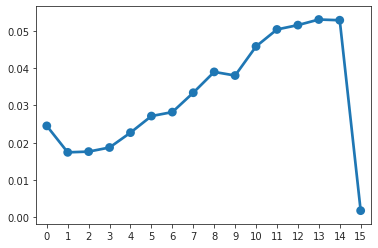

(0.94425152582548, 1.2154441763523638e-06)


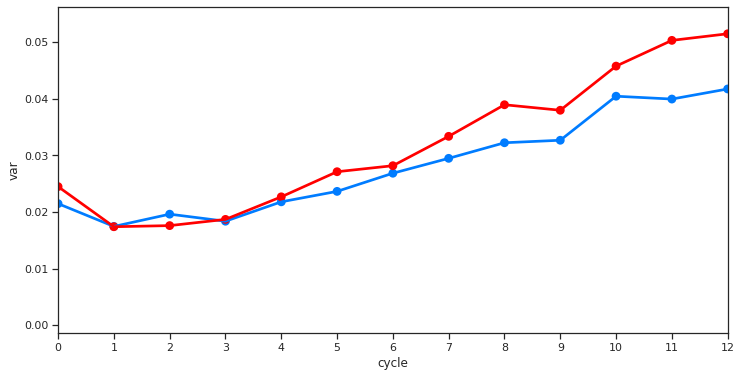

<Figure size 432x288 with 0 Axes>

In [321]:
fig, ax = plt.subplots(figsize=(12,6))

sns.pointplot(ax=ax, x=list(range(0, 16)), y=analyze_cell_stats['gc_out'].var().values, color="#007CFF")
sns.pointplot(ax=ax, x=list(range(0, 16)), y=analyze_cell_stats['gc_in'].var().values, color="#FF0000")

ax.set(xticks=range(0, 13))
ax.set_xlim([0, 12])
ax.set_ylabel('var')
ax.set_xlabel('cycle')

print(stats.pearsonr(x=list(range(0, 13)), y=analyze_cell_stats['gc_in'].var().values[:13]))

fig.savefig(base_path_artifacts + 'variance_without_normalization_tr_re.png')
fig.savefig(base_path_artifacts + 'variance_without_normalization_tr_re.eps', format='eps')
plt.show()
plt.clf()
plt.close(fig)

NameError: name 'mpl' is not defined

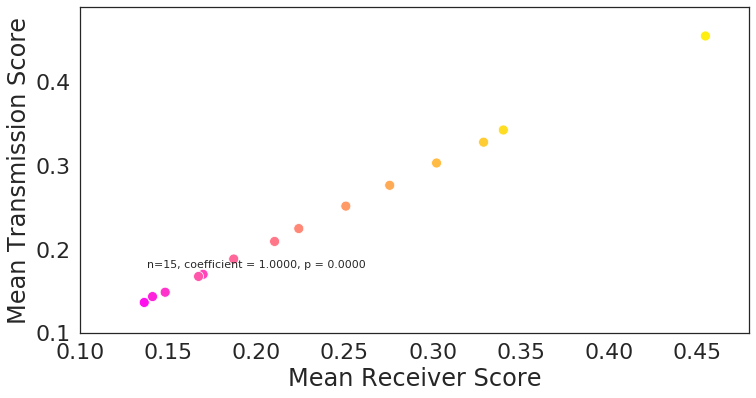

In [32]:
plot_scatter_mbar_color(x=analyze_cell_stats['gc_in'].mean(axis=0)[1:15],
                        y=analyze_cell_stats['gc_out'].mean(axis=0)[1:15],
                        x_feature_name='Mean Receiver Score',
                        y_feature_name='Mean Transmission Score',
                        save=True, 
                        hue=analyze_cell_stats.columns.levels[1][1:15],
                        hue_name='Cycle',
                        ylim=0.1,
                        xlim=0.1,
                        color_set='spring')
                        

## Anslysis of cell state

In [33]:
gc_sign_perm_test, gc_sign_cc_score = perm_test_seq_cycles(analyze_cell_stats, None, 
                                                           {'gc_out' : gc_out_score_func,
                                                            'gc_in': gc_in_score_func,                                                
                                                            'activation_time': activation_time_score_func}, step=1)
gc_sign_cc_score

NameError: name 'perm_test_seq_cycles' is not defined

In [911]:
def perm_test_feature_cycles(analyze_cell_stats,
                             kpss_and_adf_filter,
                             score_funcs_dict):
    
    number_of_parts = len(analyze_cell_stats.columns.levels[1])
    
    #minus one since it compare part i with part i+1
    perm_test = pd.DataFrame(columns=range(0, number_of_parts))
    cc_score = pd.DataFrame(columns=range(0, number_of_parts))
    
    for score_name, score_funcs in score_funcs_dict.items():        
        score_for_parts_x = score_funcs[0](analyze_cell_stats)
        score_for_parts_y = score_funcs[1](analyze_cell_stats)

        perm_test_leader_scores = {}
        parts_cc_scores = {}

        for part in range(0, number_of_parts):
            xs = score_for_parts_x[part]
            ys = score_for_parts_y[part]        

            xs = apply_custom_filter(xs, kpss_and_adf_filter)
            ys = apply_custom_filter(ys, kpss_and_adf_filter)

            perm_test_leader_scores[part] = exact_mc_perm_test(xs, ys, pearsonr, 1000, None)     

            parts_cc_scores[part] = pearsonr(xs, ys)[0]

        perm_test.loc[score_name] = perm_test_leader_scores
        cc_score.loc[score_name] = parts_cc_scores
    
    return perm_test, cc_score

activation_frame_gc_sign_perm_test, activation_frame_gc_sign_cc_score = perm_test_feature_cycles(analyze_cell_stats, None, 
                                                                        {'gc_out vs activation_time' : [gc_out_score_func, activation_time_score_func],
                                                                         'gc_in vs activation_time': [gc_in_score_func, activation_time_score_func],                                                                         
                                                                         'gc_out vs gc_in': [gc_out_score_func, gc_in_score_func]})


In [912]:
activation_frame_gc_sign_perm_test.loc[:, :12]

0      1      2      3      4      5      6  \
gc_out vs activation_time  0.0  0.004  0.966  0.021  0.075  0.002  0.000   
gc_in vs activation_time   0.0  0.002  0.117  0.256  0.151  0.653  0.239   
gc_out vs gc_in            0.0  0.000  0.000  0.000  0.000  0.000  0.000   

                               7      8      9     10     11     12  
gc_out vs activation_time  0.044  0.000  0.000  0.018  0.000  0.188  
gc_in vs activation_time   0.471  0.062  0.034  0.212  0.328  0.400  
gc_out vs gc_in            0.000  0.000  0.000  0.000  0.000  0.011

In [913]:
activation_frame_gc_sign_cc_score.loc[:, :12]

0         1         2         3         4  \
gc_out vs activation_time  0.280541  0.113993 -0.001681  0.090906  0.070943   
gc_in vs activation_time   0.230879  0.126533  0.061273  0.044325  0.058211   
gc_out vs gc_in            0.350112  0.302209  0.239153  0.191850  0.182960   

                                  5         6         7         8         9  \
gc_out vs activation_time  0.128908  0.197136  0.077399  0.132222  0.241934   
gc_in vs activation_time  -0.016966  0.045341  0.029486  0.071382  0.084483   
gc_out vs gc_in            0.302384  0.210406  0.275393  0.211083  0.192519   

                                 10        11        12  
gc_out vs activation_time  0.090867  0.138813  0.048638  
gc_in vs activation_time   0.049102  0.039190  0.033381  
gc_out vs gc_in            0.127612  0.170090  0.099001

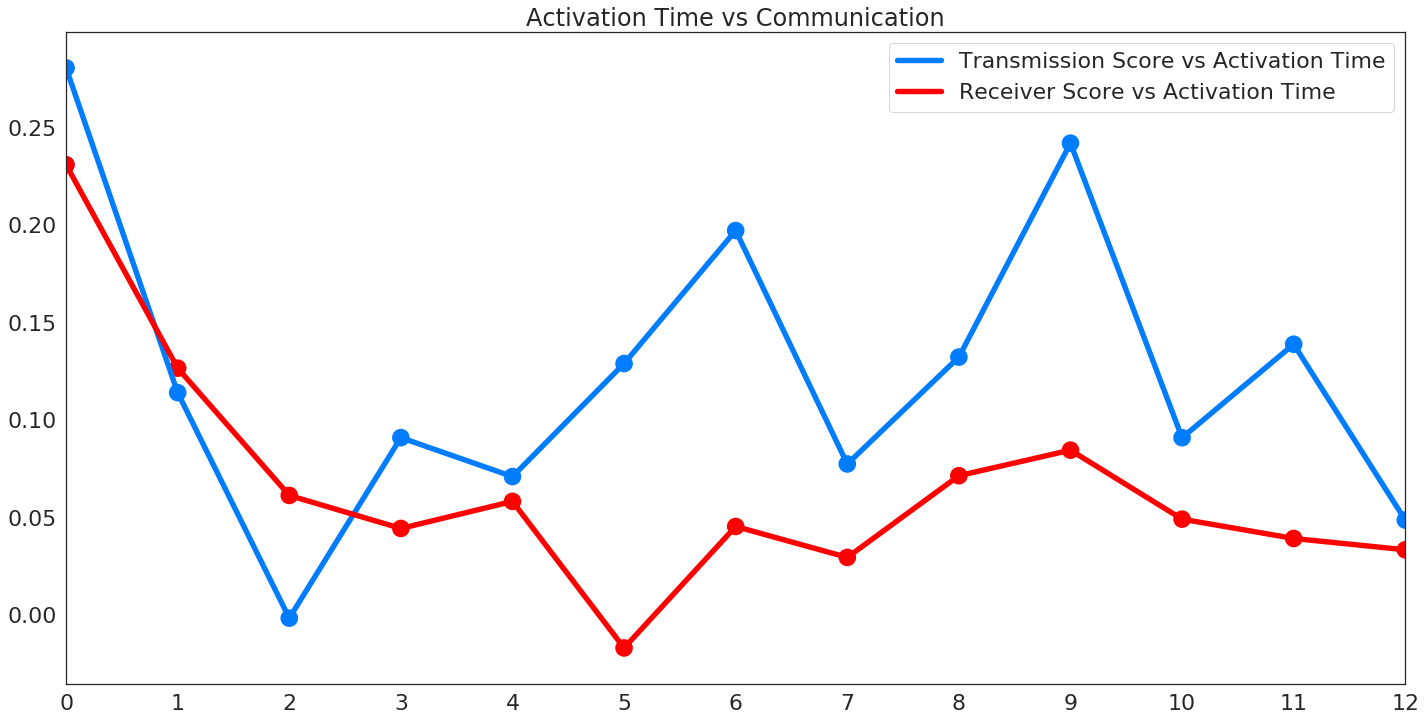

<Figure size 432x288 with 0 Axes>

In [914]:
fig, ax = plt.subplots(figsize=(24,12))

sns.pointplot(ax=ax, data=activation_frame_gc_sign_cc_score.loc[['gc_out vs activation_time'], :12], color="#007CFF")
sns.pointplot(ax=ax, data=activation_frame_gc_sign_cc_score.loc[['gc_in vs activation_time'], :12], color="#FF0000")
#ax.text(7, 0.1,'P-value=[0, 0.019]', fontsize=20) #add text
ax.set(xticks=range(0, 13))
ax.set_xlim([0, 12])
#ax.set(xlabel='correlation between cycles', ylabel='level')
ax.set_title('Activation Time vs Communication')
leg = ax.legend(['Transmission Score vs Activation Time', 'Receiver Score vs Activation Time'])
leg.legendHandles[0].set_color("#007CFF")
leg.legendHandles[1].set_color("#FF0000")

#fig.savefig(base_path_artifacts + 'activation_time_vs_communication_0.20.png')
#fig.savefig(base_path_artifacts + 'activation_time_vs_communication_0.20.eps', format='eps')
plt.show()
plt.clf()
plt.close(fig)

In [915]:
activation_frame_gc_sign_cc_score.loc[:, :12].to_csv(base_path_artifacts + 'activation_frame_gc_sign_cc_score.csv')

In [916]:
analyze_cell_stats

gc_in                                                              \
part       0.0       1.0       2.0       3.0       4.0       5.0       6.0    
1.0    0.222222  0.250000  0.222222  0.027778  0.000000  0.111111  0.111111   
2.0    0.105263  0.315789  0.000000  0.526316  0.315789  0.105263  0.157895   
3.0    0.031250  0.000000  0.187500  0.093750  0.093750  0.031250  0.218750   
4.0    0.133333  0.133333  0.000000  0.133333  0.200000  0.200000  0.066667   
5.0    0.105263  0.157895  0.052632  0.052632  0.105263  0.157895  0.105263   
...         ...       ...       ...       ...       ...       ...       ...   
669.0  0.240000  0.080000  0.360000  0.120000  0.320000  0.240000  0.200000   
670.0  0.240000  0.160000  0.000000  0.000000  0.040000  0.400000  0.040000   
671.0  0.350000  0.000000  0.350000  0.050000  0.150000  0.100000  0.050000   
672.0  0.066667  0.033333  0.066667  0.233333  0.033333  0.000000  0.000000   
673.0  0.086957  0.173913  0.000000  0.043478  0.304348  0.043478  0.000000   

                                     ... activation_time                    \
part       7.0       8.0       9.0   ...            6.0   7.0   8.0   9.0    
1.0    0.416667  0.305556  0.388889  ...             6.0  17.0   2.0   2.0   
2.0    0.052632  0.157895  0.421053  ...            12.0  19.0  21.0  18.0   
3.0    0.343750  0.250000  0.500000  ...             5.0  32.0   7.0   3.0   
4.0    0.000000  0.000000  0.066667  ...             9.0   4.0  33.0  29.0   
5.0    0.157895  0.263158  0.684211  ...            18.0   8.0  21.0   9.0   
...         ...       ...       ...  ...             ...   ...   ...   ...   
669.0  0.320000  0.280000  0.640000  ...            17.0  25.0  18.0  23.0   
670.0  0.200000  0.200000  0.200000  ...             3.0  30.0  23.0  18.0   
671.0  0.050000  0.350000  0.050000  ...             4.0  28.0   3.0   9.0   
672.0  0.000000  0.033333  0.066667  ...             6.0  15.0  15.0   9.0   
673.0  0.086957  0.086957  0.086957  ...            30.0  25.0   3.0  22.0   

                                           
part   10.0  11.0  12.0  13.0  14.0  15.0  
1.0    23.0  11.0  22.0  18.0  13.0   1.0  
2.0    16.0  12.0  18.0  23.0   4.0  27.0  
3.0    21.0   5.0  12.0  23.0  23.0  20.0  
4.0    19.0   6.0  10.0  17.0   8.0   4.0  
5.0     6.0   7.0   4.0  18.0  25.0   4.0  
...     ...   ...   ...   ...   ...   ...  
669.0  18.0  11.0  13.0   4.0  27.0  10.0  
670.0  11.0   5.0   2.0  25.0  17.0  13.0  
671.0  12.0   4.0  30.0  10.0  12.0   2.0  
672.0  11.0   5.0  27.0  15.0  16.0  27.0  
673.0   7.0  17.0   5.0  30.0  10.0   5.0  

[661 rows x 48 columns]

### Permutation test map

In [31]:
from scipy.stats import pearsonr
import numpy as np

def exact_mc_perm_test(xs, ys, operator, nmc, custom_filter):
    if custom_filter is not None:
        xs = xs[custom_filter]
        ys = ys[custom_filter]
    
    n, k = len(xs), 0.0
    diff = np.abs(operator(xs, ys)[0])
    zs = np.concatenate([xs, ys])
    for j in range(nmc):
        np.random.shuffle(zs)
        k += diff <= np.abs(operator(zs[:n],zs[n:])[0])
    return k / float(nmc)

def apply_custom_filter(ts, custom_filter):
    if custom_filter is not None:
        ts = ts[custom_filter]
        
    return ts

def gc_out_score_func(analyze_cell_stats):
    return analyze_cell_stats['gc_out']

def gc_in_score_func(analyze_cell_stats):
    return analyze_cell_stats['gc_in']

def centrality_score_func(analyze_cell_stats):
    return analyze_cell_stats['gc_out'] - analyze_cell_stats['gc_in']

def activation_time_score_func(analyze_cell_stats):
    return analyze_cell_stats['activation_time']

def perm_test_seq_cycles(analyze_cell_stats,
                         kpss_and_adf_filter,
                         score_func_dict, 
                         step):
    
    number_of_parts = len(analyze_cell_stats.columns.levels[1])
    
    #minus one since it compare part i with part i+1
    perm_test = pd.DataFrame(columns=range(0, number_of_parts - step))
    cc_score = pd.DataFrame(columns=range(0, number_of_parts - step))
    
    for score_name, score_func in score_func_dict.items():        
        score_for_parts = score_func(analyze_cell_stats)

        perm_test_leader_scores = {}
        parts_cc_scores = {}

        for part in range(0, number_of_parts - step):
            xs = score_for_parts[part]
            ys = score_for_parts[part + step]

            xs = apply_custom_filter(xs, kpss_and_adf_filter)
            ys = apply_custom_filter(ys, kpss_and_adf_filter)

            perm_test_leader_scores[part] = exact_mc_perm_test(xs, ys, pearsonr, 1000, None)     

            parts_cc_scores[part] = pearsonr(xs, ys)[0]

        perm_test.loc[score_name] = perm_test_leader_scores
        cc_score.loc[score_name] = parts_cc_scores
    
    return perm_test, cc_score

def sample_perm_seq_cycles(analyze_cell_stats,
                           score_func_dict,
                           step):
    number_of_parts = len(analyze_cell_stats.columns.levels[1])
    
    #minus one since it compare part i with part i+1
    cc_score = pd.DataFrame(columns=range(0, number_of_parts - step))
    
    for score_name, score_func in score_func_dict.items():        
        score_for_parts = score_func(analyze_cell_stats)

        parts_cc_scores = {}

        for part in range(0, number_of_parts - step):
            n = len(score_for_parts[part])
            np.random.seed(2)
            zs = np.concatenate([score_for_parts[part], score_for_parts[part + step]])
            np.random.shuffle(zs)
            
            xs = zs[:n]
            ys = zs[n:]

            parts_cc_scores[part] = pearsonr(xs, ys)[0]

        cc_score.loc[score_name] = parts_cc_scores
    
    return cc_score
    

#### Cross-Correlation map

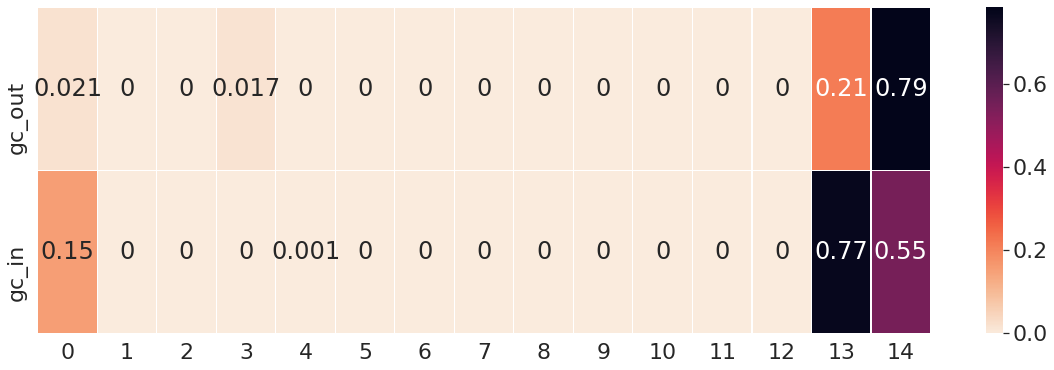

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

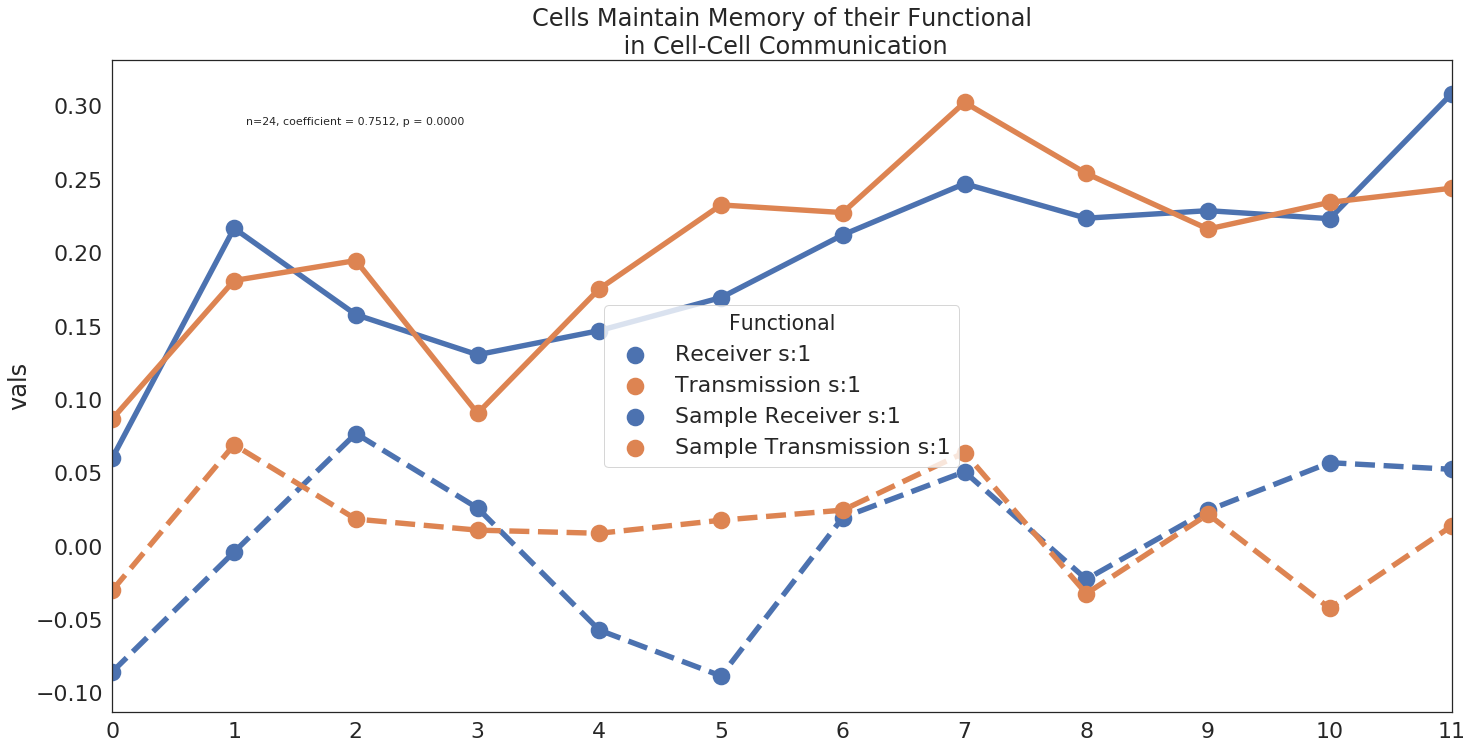

<Figure size 432x288 with 0 Axes>

In [44]:
def plot_memory_extent_over_time_heatmap(base_path_artifacts, suffix, df):
    df_new_index = pd.DataFrame(df, copy=True)
    df_new_index.index=['Δ' + str(i) for i in range(1, df.shape[0] + 1, 1)]
    fig, ax = plt.subplots(figsize=(20,6))
    ax = sns.heatmap(df_new_index, annot=True, cmap="YlGnBu", vmin=0, vmax=0.4)
    fig.savefig(base_path_artifacts + 'memory_extent_over_time_heatmap_' + suffix + '.png')
    fig.savefig(base_path_artifacts + 'memory_extent_over_time_heatmap_' + suffix + '.eps', format='eps')
    plt.clf()
    plt.close(fig)
    
    
def plot_cell_maintain_memory_of_communication_functional(base_path_artifacts, analyze_cell_stats):
    from plots_analyzetools import color_not_significant_red
    
    steps_df = None
    sample_df = None
    
    for step_corr in range(1, 2, 1):            
        gc_sign_perm_test, gc_sign_cc_score = perm_test_seq_cycles(analyze_cell_stats, None, #already filtered
                                                               {'gc_out' : gc_out_score_func,
                                                                'gc_in': gc_in_score_func},
                                                                  step_corr)

        fig, ax = plt.subplots(figsize=(20,6))
        sns.heatmap(gc_sign_perm_test, annot=True, linewidths=.2, cmap = sns.cm.rocket_r)
        fig.savefig(base_path_artifacts + 'cell_maintain_memory_of_communication_functional_perm_test_' + str(step_corr) + '.png')
        fig.savefig(base_path_artifacts + 'cell_maintain_memory_of_communication_functional_perm_test_' + str(step_corr) + '.eps', format='eps')
        plt.show()
        plt.clf()
        plt.close(fig)

        #prepeare data strcuture 
        gc_sign_cc_score_tranpose = gc_sign_cc_score.transpose()[:12][['gc_in', 'gc_out']].rename(columns={'gc_in':'Receiver', 'gc_out':'Transmission'}).stack().to_frame(name='vals')
        gc_sign_cc_score_tranpose['Functional'] = gc_sign_cc_score_tranpose.index.get_level_values(1) + ' s:' + str(step_corr) 
        
        if steps_df is None:
            steps_df = gc_sign_cc_score_tranpose
        else:
            steps_df = pd.concat([steps_df, gc_sign_cc_score_tranpose])
        
        # calculate sample cell organization
        sample_cc_score = sample_perm_seq_cycles(analyze_cell_stats,
                               {'gc_out' : gc_out_score_func,
                                'gc_in': gc_in_score_func},
                                  step_corr)
        
        #prepare sample data strcuture
        sample_cc_score_tranpose = sample_cc_score.transpose()[:12][['gc_in', 'gc_out']].rename(columns={'gc_in':'Sample Receiver', 'gc_out':'Sample Transmission'}).stack().to_frame(name='vals')
        sample_cc_score_tranpose['Functional'] = sample_cc_score_tranpose.index.get_level_values(1) + ' s:' + str(step_corr) 
        
        if sample_df is None:
            sample_df = sample_cc_score_tranpose
        else:
            sample_df = pd.concat([sample_df, sample_cc_score_tranpose])
    
    
    
    sns.set(style='white', font_scale = 2, rc={"lines.linewidth": 3})
    #sns.set_palette("terrain")

    fig, ax = plt.subplots(figsize=(24,12))
    
    sns.pointplot(ax=ax, y='vals', x=steps_df.index.get_level_values(0), data=steps_df, hue='Functional', legend=True)
    sns.pointplot(ax=ax, y='vals', x=sample_df.index.get_level_values(0), data=sample_df, hue='Functional', legend=True, linestyles=["--", "--"])
    #ax.text(7, 0.1,'P-value=[0, 0.019]', fontsize=20) #add text
    ax.set(xticks=range(0, 12))
    ax.set_xlim([0, 11])
    
    import scipy.stats as stats
    
    data_correlation = stats.pearsonr(x=steps_df.index.get_level_values(0), 
                                  y=steps_df['vals'])

    ax.annotate("n={}, coefficient = {:.4f}, p = {:.4f}".format(len(steps_df.index.get_level_values(0)),
                data_correlation[0], data_correlation[1]), 
                xy=(.1, .9), xycoords=ax.transAxes, fontsize=11)
    
    #ax.set(xlabel='correlation between cycles', ylabel='level')
    ax.set_title('Cells Maintain Memory of their Functional\n in Cell-Cell Communication')
    
    fig.savefig(base_path_artifacts + 'cell_maintain_memory_of_communication_functional.png')
    fig.savefig(base_path_artifacts + 'cell_maintain_memory_of_communication_functional.eps', format='eps')
    plt.show()
    plt.clf()
    plt.close(fig)

def plot_memory_extent_over_time(base_path_artifacts, analyze_cell_stats):
    receiver_cycle_df = None
    transmission_cycle_df = None
    activation_time_cycle_df = None
    
    for step_corr in range(1, 5, 1):        
        gc_sign_perm_test, gc_sign_cc_score = perm_test_seq_cycles(analyze_cell_stats, None, #already filtered
                                                               {'gc_out' : gc_out_score_func,
                                                                'gc_in': gc_in_score_func, 
                                                                 'activation_time': activation_time_score_func},
                                                                  step_corr)

        #prepeare data strcuture
        gc_sign_cc_score = gc_sign_cc_score.transpose()[:12][['gc_in', 'gc_out', 'activation_time']].rename(columns={'gc_in':'Receiver ' + str(step_corr), 
                                                                                                                     'gc_out':'Transmission ' + str(step_corr),
                                                                                                                    'activation_time': 'Activation Time '  + str(step_corr)}).transpose()
        gc_sign_cc_score_receiver = pd.DataFrame(gc_sign_cc_score.loc['Receiver ' + str(step_corr), :]).transpose()
        gc_sign_cc_score_transmission = pd.DataFrame(gc_sign_cc_score.loc['Transmission ' + str(step_corr), :]).transpose()
        gc_sign_cc_score_activation_time = pd.DataFrame(gc_sign_cc_score.loc['Activation Time ' + str(step_corr), :]).transpose()
        
        if receiver_cycle_df is None:
            receiver_cycle_df = gc_sign_cc_score_receiver
            transmission_cycle_df = gc_sign_cc_score_transmission
            activation_time_cycle_df = gc_sign_cc_score_activation_time
        else:
            receiver_cycle_df = pd.concat([receiver_cycle_df, gc_sign_cc_score_receiver])
            transmission_cycle_df = pd.concat([transmission_cycle_df, gc_sign_cc_score_transmission])
            activation_time_cycle_df = pd.concat([activation_time_cycle_df, gc_sign_cc_score_activation_time])
    
    #sns.set(style='white', font_scale = 1, rc={"lines.linewidth": 3})
    plot_memory_extent_over_time_heatmap(base_path_artifacts,'Receiver', receiver_cycle_df)
    plot_memory_extent_over_time_heatmap(base_path_artifacts,'Transmission', transmission_cycle_df)
    plot_memory_extent_over_time_heatmap(base_path_artifacts,'Activation Time', activation_time_cycle_df)

#plot_memory_extent_over_time(base_path_artifacts, analyze_cell_stats)
plot_cell_maintain_memory_of_communication_functional(base_path_artifacts, analyze_cell_stats)

## Video of network cell function state over time

In [920]:
import random
import pylab
from matplotlib.pyplot import pause
import networkx as nx
from matplotlib import animation, rc
from IPython.display import HTML
from plots_analyzetools import plot_voronoi, plot_colormap
import matplotlib as mpl

def create_color_mapper(analyze_cell_stats, score_func, cmap):
    minima = 20
    maxima = -20
    
    number_of_parts = len(analyze_cell_stats.columns.levels[1])
    
    for part in range(0, number_of_parts):        
        maxima = np.maximum(maxima, np.max(score_func(analyze_cell_stats)[part]))
        minima = np.minimum(minima, np.min(score_func(analyze_cell_stats)[part]))
    
    norm = mpl.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
    mapper = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    
    return mapper

def plot_correlation(ax, part):
    sns.set(style='white', font_scale = 2, rc={"lines.linewidth": 4})
    sns.set_palette('Set1')
    
    part_t = 0
    
    if part > 1:
        part_t = part - 1

    sns.lineplot(data=gc_sign_cc_score.transpose().drop(['activation_time', 'centrality'], axis=1)[:part_t],
                markers=True, dashes=False,
                legend=False, 
                ax=ax)
    ax.text(0.6, 0.1,'P-value=[0, 0.019]', fontsize=20, transform=ax.transAxes) #add text
    ax.set(xticks=range(0, 12))
    ax.set_ylim([0, 0.35])
    ax.set_xlim([0, 11])
    ax.set_title("Cross-Correlation(Cycle %d,  Cycle %d)"%(part_t, part_t + 1), fontweight="bold")

    ax.legend(loc='upper left', labels=['Transmission', 'Receiver'])

def make_movie(analyze_cell_stats, score_func, metric_name, base_path_artifacts, colormap=mpl.cm.Blues):
    # Build plot
    fig, axs = plt.subplots(figsize=(12,10), nrows=1, ncols=1)
    
    score_for_parts = score_func(analyze_cell_stats)
    mapper = create_color_mapper(analyze_cell_stats, score_func, cmap=colormap)
    plot_colormap(mapper)
    #plt.suptitle('Cells Maintain Memory of their Functional\n in Cell-Cell Communication')
    #plt.subplots_adjust(top=0.80)

    def update(part):        
        data = score_for_parts[part]
        #data = apply_custom_filter(data, kpss_and_adf_filter)
        #custom_filter = np.greater(data, np.zeros((len(data))))
        custom_filter = data != 0
        
        custom_filter = custom_filter.reindex(list(range(int(np.min(np.hstack(regions))),
                                                         int(np.max(np.hstack(regions)))+1)), fill_value=False)
        
        plot_voronoi(axs, mapper, regions, vertices, vor, centroids, 
                         data,
                         custom_filter)

        # Scale plot ax
        axs.set_title("Cycle %d"%(part), fontweight="bold")
        axs.set_xticks([])
        axs.set_yticks([])
        fig.savefig(base_path_artifacts + metric_name + '_snapshot_' + str(part) + '_cells_memory.png')
        fig.savefig(base_path_artifacts + metric_name + '_snapshot_' + str(part) + '_cells_memory.eps', format='eps')
        
        #plot_correlation(axs[0], part)

    anim = animation.FuncAnimation(fig, update, frames=13, interval=500, repeat=True)
    
    anim.save(base_path_artifacts + metric_name + '_cells_memory.mp4')

    return HTML(anim.to_html5_video())

def plot_leadership_followership_movies(analyze_cell_stats, base_path_artifacts):
    sns.set(style='white', font_scale = 2, rc={"lines.linewidth": 4})

    #leadership_movie = make_movie(analyze_cell_stats, gc_out_score_func, 'Transmission Score', base_path_artifacts, colormap=mpl.cm.Blues)

    #followership_movie = make_movie(analyze_cell_stats, gc_in_score_func, 'Receiver Score', base_path_artifacts, colormap=mpl.cm.Reds)
    
    activation_time = make_movie(analyze_cell_stats, activation_time_score_func, 'Activation Time', base_path_artifacts, colormap=mpl.cm.Greens)

    sns.set()

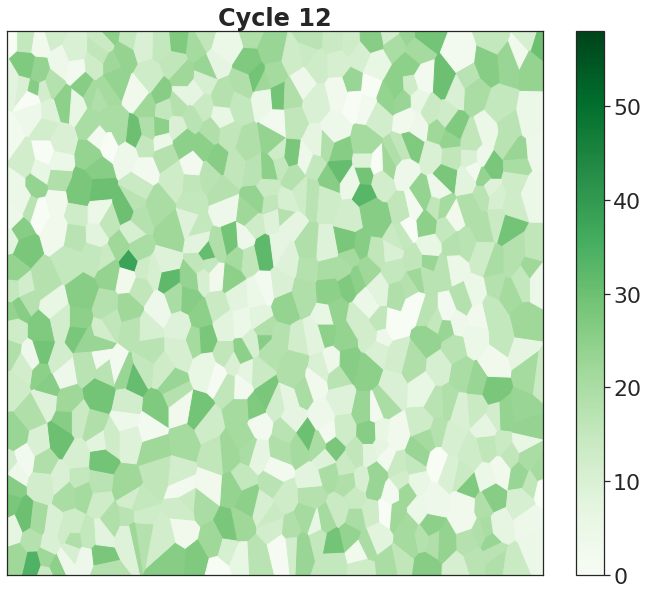

In [921]:
plot_leadership_followership_movies(analyze_cell_stats, base_path_artifacts)

In [922]:
analyze_cell_stats

gc_in                                                              \
part       0.0       1.0       2.0       3.0       4.0       5.0       6.0    
1.0    0.222222  0.250000  0.222222  0.027778  0.000000  0.111111  0.111111   
2.0    0.105263  0.315789  0.000000  0.526316  0.315789  0.105263  0.157895   
3.0    0.031250  0.000000  0.187500  0.093750  0.093750  0.031250  0.218750   
4.0    0.133333  0.133333  0.000000  0.133333  0.200000  0.200000  0.066667   
5.0    0.105263  0.157895  0.052632  0.052632  0.105263  0.157895  0.105263   
...         ...       ...       ...       ...       ...       ...       ...   
669.0  0.240000  0.080000  0.360000  0.120000  0.320000  0.240000  0.200000   
670.0  0.240000  0.160000  0.000000  0.000000  0.040000  0.400000  0.040000   
671.0  0.350000  0.000000  0.350000  0.050000  0.150000  0.100000  0.050000   
672.0  0.066667  0.033333  0.066667  0.233333  0.033333  0.000000  0.000000   
673.0  0.086957  0.173913  0.000000  0.043478  0.304348  0.043478  0.000000   

                                     ... activation_time                    \
part       7.0       8.0       9.0   ...            6.0   7.0   8.0   9.0    
1.0    0.416667  0.305556  0.388889  ...             6.0  17.0   2.0   2.0   
2.0    0.052632  0.157895  0.421053  ...            12.0  19.0  21.0  18.0   
3.0    0.343750  0.250000  0.500000  ...             5.0  32.0   7.0   3.0   
4.0    0.000000  0.000000  0.066667  ...             9.0   4.0  33.0  29.0   
5.0    0.157895  0.263158  0.684211  ...            18.0   8.0  21.0   9.0   
...         ...       ...       ...  ...             ...   ...   ...   ...   
669.0  0.320000  0.280000  0.640000  ...            17.0  25.0  18.0  23.0   
670.0  0.200000  0.200000  0.200000  ...             3.0  30.0  23.0  18.0   
671.0  0.050000  0.350000  0.050000  ...             4.0  28.0   3.0   9.0   
672.0  0.000000  0.033333  0.066667  ...             6.0  15.0  15.0   9.0   
673.0  0.086957  0.086957  0.086957  ...            30.0  25.0   3.0  22.0   

                                           
part   10.0  11.0  12.0  13.0  14.0  15.0  
1.0    23.0  11.0  22.0  18.0  13.0   1.0  
2.0    16.0  12.0  18.0  23.0   4.0  27.0  
3.0    21.0   5.0  12.0  23.0  23.0  20.0  
4.0    19.0   6.0  10.0  17.0   8.0   4.0  
5.0     6.0   7.0   4.0  18.0  25.0   4.0  
...     ...   ...   ...   ...   ...   ...  
669.0  18.0  11.0  13.0   4.0  27.0  10.0  
670.0  11.0   5.0   2.0  25.0  17.0  13.0  
671.0  12.0   4.0  30.0  10.0  12.0   2.0  
672.0  11.0   5.0  27.0  15.0  16.0  27.0  
673.0   7.0  17.0   5.0  30.0  10.0   5.0  

[661 rows x 48 columns]

## Enrichment of Hub

In [44]:
## define the roles
from sklearn.preprocessing import StandardScaler  # For scaling dataset
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

def standard_df(df):
    pipe_norm = make_pipeline(StandardScaler())
    pipe_norm.fit(df)
    transformed_norm = pipe_norm.transform(df)
    
    return transformed_norm, pipe_norm

def transle_role(role):
    if (role == 0):
        return 'Hub'
    elif (role == 1):
        return 'Leader'        
    elif (role == 2):
        return 'Follower'        
    elif (role == 3):
        return 'Common'        
    else:
        return 'Individual'        

def get_role(row, threshold):    
    if (row[0] >= threshold and row[1] >= threshold):
        return 0
    elif (row[0] <= -threshold and row[1] <= -threshold):
        return 4
    elif (row[0] >= threshold and row[1] < threshold):
        return 2
    elif (row[0] < threshold and row[1] >= threshold):
        return 1
    else:
        return 3

def plot_data(dpc, con_analyze_cell_stats_flat):
    fig = plt.figure(figsize=(15, 5))
    ax = []    
    ax.append(fig.add_subplot(1, 3, 1))
    ax.append(fig.add_subplot(1, 3, 2))
    ax.append(fig.add_subplot(1, 3, 3))
    ax[0].scatter(con_analyze_cell_stats_flat[:, 0], con_analyze_cell_stats_flat[:, 1], s=40)
    ax[0].scatter(con_analyze_cell_stats_flat[dpc.clusters, 0], con_analyze_cell_stats_flat[dpc.clusters, 1],  s=50, c="red")
    ax[1].scatter(con_analyze_cell_stats_flat[:, 0], con_analyze_cell_stats_flat[:, 1], s=40, c=dpc.density)
    ax[2].scatter(con_analyze_cell_stats_flat[:, 0], con_analyze_cell_stats_flat[:, 1], s=40, c=dpc.membership, cmap=mpl.cm.cool)
    for _ax in ax:
        #_ax.plot([-mux, -mux], [-1.5 * muy, 1.5 * muy], '--', linewidth=2, color="red")
        #_ax.plot([mux, mux], [-1.5 * muy, 1.5 * muy], '--', linewidth=2, color="red")
        #_ax.plot([-1.5 * mux,  1.5 * mux], [-muy, -muy], '--', linewidth=2, color="red")
        #_ax.plot([-1.5 * mux,  1.5 * mux], [muy, muy], '--', linewidth=2, color="red")
        _ax.set_xlabel(r"gc in-degree", fontsize=15)
        _ax.set_ylabel(r"gc out-degree", fontsize=15)    
        _ax.tick_params(labelsize=10)
        #_ax.set_xlim([-7, 7])
        #_ax.set_ylim([-7, 7])
        _ax.set_aspect('equal')
    fig.tight_layout()
    
analyze_cell_stats_flat = analyze_cell_stats.stack()

con_analyze_cell_stats_flat = analyze_cell_stats_flat[['gc_in','gc_out']].values.copy(order='C')

transformed_norm_df, pipe_norm_df = standard_df(analyze_cell_stats_flat[['gc_in','gc_out']].loc[pd.IndexSlice[:, :], :])

analyze_cell_stats_flat['Manual_0.5'] = np.apply_along_axis(lambda row: get_role(row, 0.5), 1, transformed_norm_df)

# Calculate Roles Encrichment for Individual and Common

In [57]:
analyze_cell_stats_flat[['gc_in_norm', 'gc_out_norm']] = transformed_norm_df

In [63]:
cell_states_norm = analyze_cell_stats_flat.unstack()

In [86]:
cell_states_norm[[('gc_in_norm', 0), ('gc_out_norm', 0)]].shape

(661, 2)

In [96]:
#individual
individual_enrichment_results = pd.DataFrame(columns=['cycle', 'p(individual)', 'p(re-zscore<-0.5) * p(tr-zscore < -0.5)'])
for cycle in range(0, 13):    
    individual_enrichment_results=individual_enrichment_results.append({'cycle': cycle,
                                                                       'p(individual)': (len(cell_states_norm[[('gc_in_norm', cycle), ('gc_out_norm', cycle)]][(cell_states_norm[('gc_in_norm', cycle)] < -0.5) & (cell_states_norm[('gc_out_norm', cycle)] < -0.5)])
                                                                                                                 /cell_states_norm[[('gc_in_norm', cycle), ('gc_out_norm', cycle)]].shape[0]),
                                                                       'p(re-zscore<-0.5) * p(tr-zscore < -0.5)': ((len(cell_states_norm[[('gc_in_norm', cycle)]][(cell_states_norm[('gc_in_norm', cycle)] < -0.5)])/cell_states_norm[[('gc_in_norm', cycle), ('gc_out_norm', cycle)]].shape[0])
                                                                                                                * (len(cell_states_norm[[('gc_out_norm', cycle)]][(cell_states_norm[('gc_out_norm', cycle)] < -0.5)])/cell_states_norm[[('gc_in_norm', cycle), ('gc_out_norm', cycle)]].shape[0]))},                                                    
                                                                        ignore_index=True)
individual_enrichment_results

cycle  p(individual)  p(re-zscore<-0.5) * p(tr-zscore < -0.5)
0     0.0       0.232980                                 0.165613
1     1.0       0.358548                                 0.314796
2     2.0       0.329803                                 0.302801
3     3.0       0.332829                                 0.291513
4     4.0       0.269289                                 0.220658
5     5.0       0.314675                                 0.263022
6     6.0       0.236006                                 0.201851
7     7.0       0.213313                                 0.160670
8     8.0       0.189107                                 0.140131
9     9.0       0.131619                                 0.098379
10   10.0       0.102874                                 0.082853
11   11.0       0.086233                                 0.059393
12   12.0       0.052950                                 0.039481

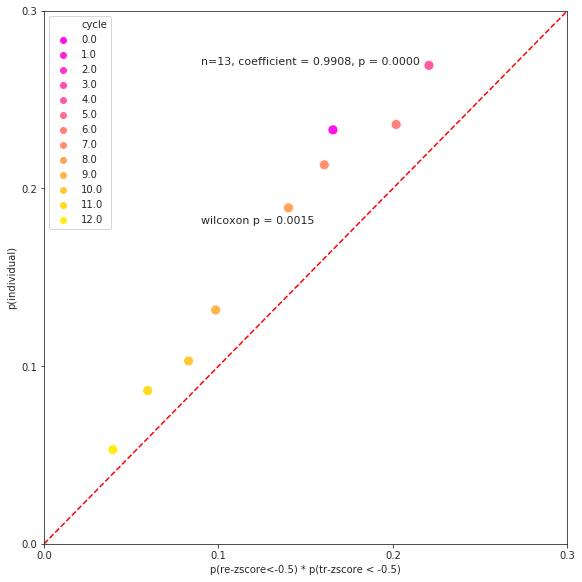

<Figure size 432x288 with 0 Axes>

In [100]:
fig, ax = plt.subplots(figsize=(8,8))
ax = sns.scatterplot(ax=ax, x='p(re-zscore<-0.5) * p(tr-zscore < -0.5)', y='p(individual)', hue='cycle', data=individual_enrichment_results, s=100, palette=sns.color_palette('spring', individual_enrichment_results.shape[0]))

ticks_range = np.arange(0.0, 0.5, step=0.1)

ax.set(xlim=(0.0, 0.3), ylim=(0.0, 0.3), xticks=ticks_range, yticks=ticks_range)

plt.plot(ticks_range, ticks_range, 'r--')

data_correlation = stats.pearsonr(x=individual_enrichment_results['p(re-zscore<-0.5) * p(tr-zscore < -0.5)'], 
                                  y=individual_enrichment_results['p(individual)'])

ax.annotate("n={}, coefficient = {:.4f}, p = {:.4f}".format(len(individual_enrichment_results),
            data_correlation[0], data_correlation[1]), 
            xy=(.3, .9), xycoords=ax.transAxes, fontsize=11)

from scipy.stats import wilcoxon

ax.annotate("wilcoxon p = {:.4f}".format(wilcoxon(individual_enrichment_results['p(re-zscore<-0.5) * p(tr-zscore < -0.5)'],
                                            individual_enrichment_results['p(individual)'])[1]),
            xy=(.3, .6), xycoords=ax.transAxes, fontsize=11)

plt.tight_layout(pad=0.4, w_pad=2, h_pad=1.0)


#fig.savefig(base_path_artifacts + 'roles_leadership_followership_vs_hub.png')
#plt.savefig(base_path_artifacts + 'roles_leadership_followership_vs_hub.eps', format='eps')
plt.show()
plt.clf()
plt.close(fig)

In [101]:
#individual
hub_enrichment_results = pd.DataFrame(columns=['cycle', 'p(hub)', 'p(re-zscore>0.5) * p(tr-zscore > 0.5)'])
for cycle in range(0, 13):    
    hub_enrichment_results=hub_enrichment_results.append({'cycle': cycle,
                                                           'p(hub)': (len(cell_states_norm[[('gc_in_norm', cycle), ('gc_out_norm', cycle)]][(cell_states_norm[('gc_in_norm', cycle)] > 0.5) & (cell_states_norm[('gc_out_norm', cycle)] > 0.5)])
                                                                                                     /cell_states_norm[[('gc_in_norm', cycle), ('gc_out_norm', cycle)]].shape[0]),
                                                           'p(re-zscore>0.5) * p(tr-zscore > 0.5)': ((len(cell_states_norm[[('gc_in_norm', cycle)]][(cell_states_norm[('gc_in_norm', cycle)] > 0.5)])/cell_states_norm[[('gc_in_norm', cycle), ('gc_out_norm', cycle)]].shape[0])
                                                                                                    * (len(cell_states_norm[[('gc_out_norm', cycle)]][(cell_states_norm[('gc_out_norm', cycle)] > 0.5)])/cell_states_norm[[('gc_in_norm', cycle), ('gc_out_norm', cycle)]].shape[0]))},                                                    
                                                            ignore_index=True)
hub_enrichment_results

cycle    p(hub)  p(re-zscore>0.5) * p(tr-zscore > 0.5)
0     0.0  0.060514                               0.037723
1     1.0  0.030257                               0.010121
2     2.0  0.027231                               0.012002
3     3.0  0.022693                               0.014202
4     4.0  0.040847                               0.024993
5     5.0  0.060514                               0.031811
6     6.0  0.057489                               0.045180
7     7.0  0.081694                               0.056028
8     8.0  0.095310                               0.076224
9     9.0  0.134644                               0.115325
10   10.0  0.160363                               0.141758
11   11.0  0.208775                               0.191101
12   12.0  0.246596                               0.227753

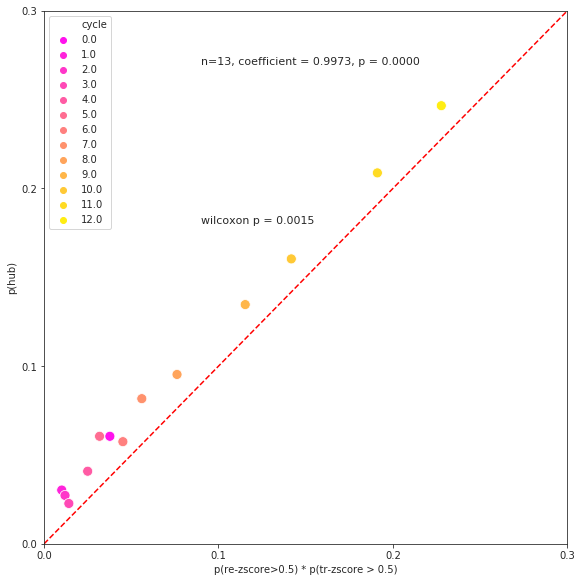

<Figure size 432x288 with 0 Axes>

In [104]:
fig, ax = plt.subplots(figsize=(8,8))
ax = sns.scatterplot(ax=ax, x='p(re-zscore>0.5) * p(tr-zscore > 0.5)', y='p(hub)', hue='cycle', data=hub_enrichment_results, s=100, palette=sns.color_palette('spring', hub_enrichment_results.shape[0]))

ticks_range = np.arange(0.0, 0.5, step=0.1)

ax.set(xlim=(0.0, 0.3), ylim=(0.0, 0.3), xticks=ticks_range, yticks=ticks_range)

plt.plot(ticks_range, ticks_range, 'r--')

data_correlation = stats.pearsonr(x=hub_enrichment_results['p(re-zscore>0.5) * p(tr-zscore > 0.5)'], 
                                  y=hub_enrichment_results['p(hub)'])

ax.annotate("n={}, coefficient = {:.4f}, p = {:.4f}".format(len(hub_enrichment_results),
            data_correlation[0], data_correlation[1]), 
            xy=(.3, .9), xycoords=ax.transAxes, fontsize=11)

from scipy.stats import wilcoxon

ax.annotate("wilcoxon p = {:.4f}".format(wilcoxon(hub_enrichment_results['p(re-zscore>0.5) * p(tr-zscore > 0.5)'],
                                            hub_enrichment_results['p(hub)'])[1]),
            xy=(.3, .6), xycoords=ax.transAxes, fontsize=11)

plt.tight_layout(pad=0.4, w_pad=2, h_pad=1.0)


#fig.savefig(base_path_artifacts + 'roles_leadership_followership_vs_hub.png')
#plt.savefig(base_path_artifacts + 'roles_leadership_followership_vs_hub.eps', format='eps')
plt.show()
plt.clf()
plt.close(fig)

In [118]:
#individual
common_enrichment_results = pd.DataFrame(columns=['cycle', 'p(common)', 'p(re-zscore <=0.5 & -0.5 <= tr-zscore  <= 0.5) * p(tr-zscore <= 0.5 & -0.5 <= re-zscore  <= 0.5)'])
for cycle in range(0, 13):
    tr_area_cond = (cell_states_norm[('gc_in_norm', cycle)] <= 0.5) & (cell_states_norm[('gc_out_norm', cycle)] <= 0.5) & (cell_states_norm[('gc_out_norm', cycle)] >= -0.5)
    re_area_cond = (cell_states_norm[('gc_out_norm', cycle)] <= 0.5) & (cell_states_norm[('gc_in_norm', cycle)] <= 0.5) & (cell_states_norm[('gc_in_norm', cycle)] >= -0.5)

    common_enrichment_results=common_enrichment_results.append({'cycle': cycle,
                                                           'p(common)': (len(cell_states_norm[[('gc_in_norm', cycle), ('gc_out_norm', cycle)]][tr_area_cond & re_area_cond])
                                                                                                     /cell_states_norm[[('gc_in_norm', cycle), ('gc_out_norm', cycle)]].shape[0]),
                                                           'p(re-zscore <=0.5 & -0.5 <= tr-zscore  <= 0.5) * p(tr-zscore <= 0.5 & -0.5 <= re-zscore  <= 0.5)': ((len(cell_states_norm[[('gc_in_norm', cycle)]][tr_area_cond])/cell_states_norm[[('gc_in_norm', cycle), ('gc_out_norm', cycle)]].shape[0])
                                                                                                    * (len(cell_states_norm[[('gc_out_norm', cycle)]][re_area_cond])/cell_states_norm[[('gc_in_norm', cycle), ('gc_out_norm', cycle)]].shape[0]))},
                                                            ignore_index=True)
common_enrichment_results

cycle  p(common)  \
0     0.0   0.161876   
1     1.0   0.113464   
2     2.0   0.122542   
3     3.0   0.122542   
4     4.0   0.164902   
5     5.0   0.101362   
6     6.0   0.124054   
7     7.0   0.133132   
8     8.0   0.128593   
9     9.0   0.114977   
10   10.0   0.111952   
11   11.0   0.096823   
12   12.0   0.105900   

    p(re-zscore <=0.5 & -0.5 <= tr-zscore  <= 0.5) * p(tr-zscore <= 0.5 & -0.5 <= re-zscore  <= 0.5)  
0                                            0.090176                                                 
1                                            0.085025                                                 
2                                            0.089559                                                 
3                                            0.082120                                                 
4                                            0.096164                                                 
5                                            0.060063                                                 
6                                            0.067701                                                 
7                                            0.069688                                                 
8                                            0.058180                                                 
9                                            0.048121                                                 
10                                           0.043266                                                 
11                                           0.029662                                                 
12                                           0.029742

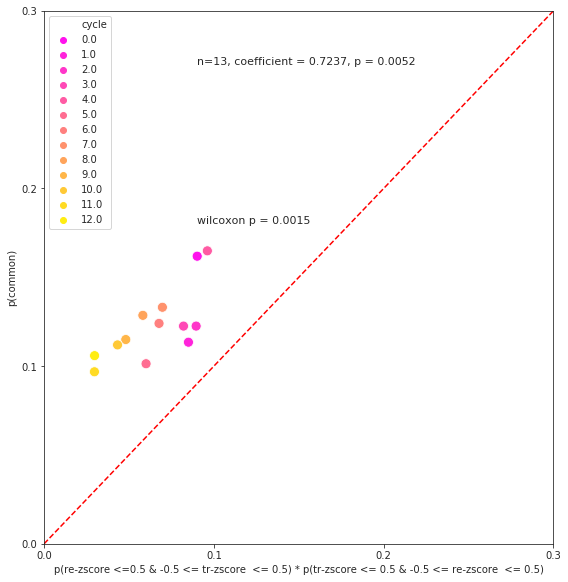

<Figure size 432x288 with 0 Axes>

In [119]:
fig, ax = plt.subplots(figsize=(8,8))
ax = sns.scatterplot(ax=ax, x='p(re-zscore <=0.5 & -0.5 <= tr-zscore  <= 0.5) * p(tr-zscore <= 0.5 & -0.5 <= re-zscore  <= 0.5)', y='p(common)', hue='cycle', data=common_enrichment_results, s=100, palette=sns.color_palette('spring', hub_enrichment_results.shape[0]))

ticks_range = np.arange(0.0, 0.5, step=0.1)

ax.set(xlim=(0.0, 0.3), ylim=(0.0, 0.3), xticks=ticks_range, yticks=ticks_range)

plt.plot(ticks_range, ticks_range, 'r--')

data_correlation = stats.pearsonr(x=common_enrichment_results['p(re-zscore <=0.5 & -0.5 <= tr-zscore  <= 0.5) * p(tr-zscore <= 0.5 & -0.5 <= re-zscore  <= 0.5)'], 
                                  y=common_enrichment_results['p(common)'])

ax.annotate("n={}, coefficient = {:.4f}, p = {:.4f}".format(len(common_enrichment_results),
            data_correlation[0], data_correlation[1]), 
            xy=(.3, .9), xycoords=ax.transAxes, fontsize=11)

from scipy.stats import wilcoxon

ax.annotate("wilcoxon p = {:.4f}".format(wilcoxon(common_enrichment_results['p(re-zscore <=0.5 & -0.5 <= tr-zscore  <= 0.5) * p(tr-zscore <= 0.5 & -0.5 <= re-zscore  <= 0.5)'],
                                            common_enrichment_results['p(common)'])[1]),
            xy=(.3, .6), xycoords=ax.transAxes, fontsize=11)

plt.tight_layout(pad=0.4, w_pad=2, h_pad=1.0)


#fig.savefig(base_path_artifacts + 'roles_leadership_followership_vs_hub.png')
#plt.savefig(base_path_artifacts + 'roles_leadership_followership_vs_hub.eps', format='eps')
plt.show()
plt.clf()
plt.close(fig)

# Cells roles coded over cycles

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

['#1f77b4', '#d62728', '#2ca02c', '#9467bd', '#ff7f0e']


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

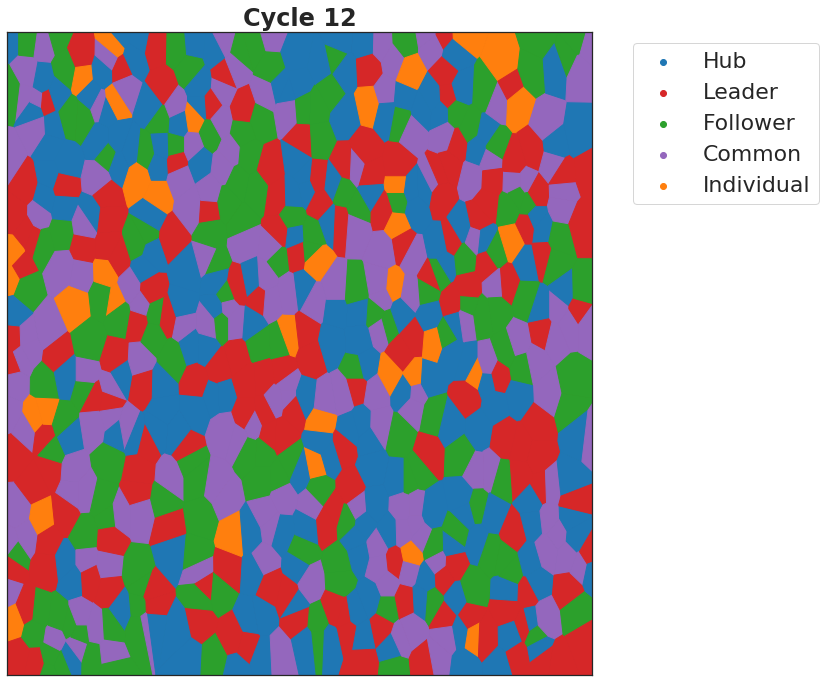

In [290]:
import random
import pylab
from matplotlib.pyplot import pause
import networkx as nx
from matplotlib import animation, rc
from IPython.display import HTML
from plots_analyzetools import plot_voronoi, plot_colormap
import matplotlib as mpl

def plot_voronoi_roles(ax, color_pattle, regions, vertices, vor, points, data, custom_filter):    
    number_of_regions = len(regions)
    
    for region_index in range(0, number_of_regions):
        region = regions[region_index]
        node_index = np.where(vor.point_region == region_index)[0]
        
        node_score = 0
        
        if (len(node_index) != 0) and custom_filter[node_index[0]]:
            node_score = data[node_index[0]]
                
        polygon = vertices[region]      
        ax.fill(*zip(*polygon), alpha=1, color=color_pattle[node_score])
    
    #ax.plot(points[:,0], points[:,1], 'ko')
    ax.set_xlim(vor.min_bound[0] - 0.1, vor.max_bound[0] + 0.1)
    ax.set_ylim(vor.min_bound[1] - 0.1, vor.max_bound[1] + 0.1)

def create_color_mapper_roles(analyze_cell_stats, cmap):
    minima = 20
    maxima = -20
    
    number_of_parts = analyze_cell_stats.shape[1]
    
    for part in range(0, number_of_parts):        
        maxima = np.maximum(maxima, np.max(analyze_cell_stats)[part])
        minima = np.minimum(minima, np.min(analyze_cell_stats)[part])
    
    norm = mpl.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
    mapper = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    
    return mapper

def make_movie_roles(analyze_cell_roles, metric_name, base_path_artifacts):
    # Build plot
    fig, axs = plt.subplots(figsize=(12,10), nrows=1, ncols=1)
    
    colors = ['#1f77b4', '#d62728', '#2ca02c', '#9467bd', '#ff7f0e']
    print(colors)
    cmap = mpl.colors.ListedColormap(colors)
    
    #mapper = create_color_mapper_roles(analyze_cell_roles, cmap=cmap)
    #mapper=cmap
    [axs.scatter([], [], c=cmap(i), label=transle_role(i)) for i in range(len(colors))]    
    axs.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

    #plt.suptitle('Cells Maintain Memory of their Functional\n in Cell-Cell Communication')
    #plt.subplots_adjust(top=0.80)

    def update(part):        
        data = analyze_cell_roles[part]
        #data = apply_custom_filter(data, kpss_and_adf_filter)
        #custom_filter = np.greater(data, np.zeros((len(data))))
        custom_filter = data != 0
        
        custom_filter = custom_filter.reindex(list(range(int(np.min(np.hstack(regions))),
                                                         int(np.max(np.hstack(regions)))+1)), fill_value=False)
        
        plot_voronoi_roles(axs, colors, regions, vertices, vor, centroids, 
                         data,
                         custom_filter)

        # Scale plot ax
        axs.set_title("Cycle %d"%(part), fontweight="bold")
        axs.set_xticks([])
        axs.set_yticks([])
        plt.tight_layout()
        fig.savefig(base_path_artifacts + metric_name + '_snapshot_' + str(part) + '_cells_memory.png')
        fig.savefig(base_path_artifacts + metric_name + '_snapshot_' + str(part) + '_cells_memory.eps', format='eps')

    anim = animation.FuncAnimation(fig, update, frames=13, interval=500, repeat=True)
    
    anim.save(base_path_artifacts + metric_name + '_cells_memory.mp4')

    return HTML(anim.to_html5_video())

def plot_roles_movies(analyze_cell_roles, base_path_artifacts):
    sns.set(style='white', font_scale = 2, rc={"lines.linewidth": 4})

    roles_movie = make_movie_roles(analyze_cell_roles, 'Cells Roles', base_path_artifacts)

    sns.set()

plot_roles_movies(analyze_cell_stats_flat['Manual_0.5'].unstack(), base_path_artifacts)

In [81]:
analyze_cell_stats_flat['Manual_0.5'].unstack()

1.0      1
2.0      3
3.0      4
4.0      3
5.0      4
        ..
669.0    3
670.0    3
671.0    2
672.0    3
673.0    3
Name: 0.0, Length: 661, dtype: int64

In [37]:
np.hstack((transformed_norm_df, analyze_cell_stats_flat['activation_time'].values.reshape(-1 , 1)))

array([[-8.07239470e-04,  1.97892189e+00,  4.00000000e+00],
       [ 1.34477559e-01, -4.31293083e-01,  5.00000000e+00],
       [-8.07239470e-04, -8.56625137e-01,  3.00000000e+00],
       ...,
       [ 1.87415089e-01,  1.91294418e-01,  1.10000000e+01],
       [ 2.30491628e+00,  1.30085630e+00,  1.00000000e+01],
       [-8.71335507e-01, -9.18267464e-01,  2.00000000e+00]])

In [38]:
pd.DataFrame(np.hstack((transformed_norm_df, analyze_cell_stats_flat['activation_time'].values.reshape(-1 , 1))), index=analyze_cell_stats_flat.index, columns=analyze_cell_stats_flat[['gc_in','gc_out', 'activation_time']].columns)

gc_in    gc_out  activation_time
      part                                     
1.0   0.0  -0.000807  1.978922              4.0
      1.0   0.134478 -0.431293              5.0
      2.0  -0.000807 -0.856625              3.0
      3.0  -0.947801 -0.289516              3.0
      4.0  -1.083086 -0.573070              4.0
...              ...       ...              ...
673.0 11.0  0.187415  0.413207              8.0
      12.0 -1.083086  0.857032              3.0
      13.0  0.187415  0.191294             11.0
      14.0  2.304916  1.300856             10.0
      15.0 -0.871336 -0.918267              2.0

[10576 rows x 3 columns]

# Clustring

## Manual

3
cycle: 0, length: 0.7703506999485191, ratio: 0.6752763028962763, degree: 43.46685278355497, comp_idx:0
cycle: 0, length: 0.37044262664159877, ratio: 0.3247236971037237, degree: 133.46685278355497, comp_idx:1
cycle: 1, length: 0.5663899655823827, ratio: 0.6528514817007939, degree: 49.54979629421915, comp_idx:0
cycle: 1, length: 0.30117330333574316, ratio: 0.3471485182992062, degree: 139.54979629421914, comp_idx:1
cycle: 2, length: 0.5843941631058568, ratio: 0.6292275594180358, degree: 56.493555442669404, comp_idx:0
cycle: 2, length: 0.34435435459472713, ratio: 0.3707724405819643, degree: 146.49355544266942, comp_idx:1
cycle: 3, length: 0.551316543257899, ratio: 0.59773050445156, degree: 50.62061329864074, comp_idx:0
cycle: 3, length: 0.37103314301710977, ratio: 0.4022694955484401, degree: -39.37938670135925, comp_idx:1


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

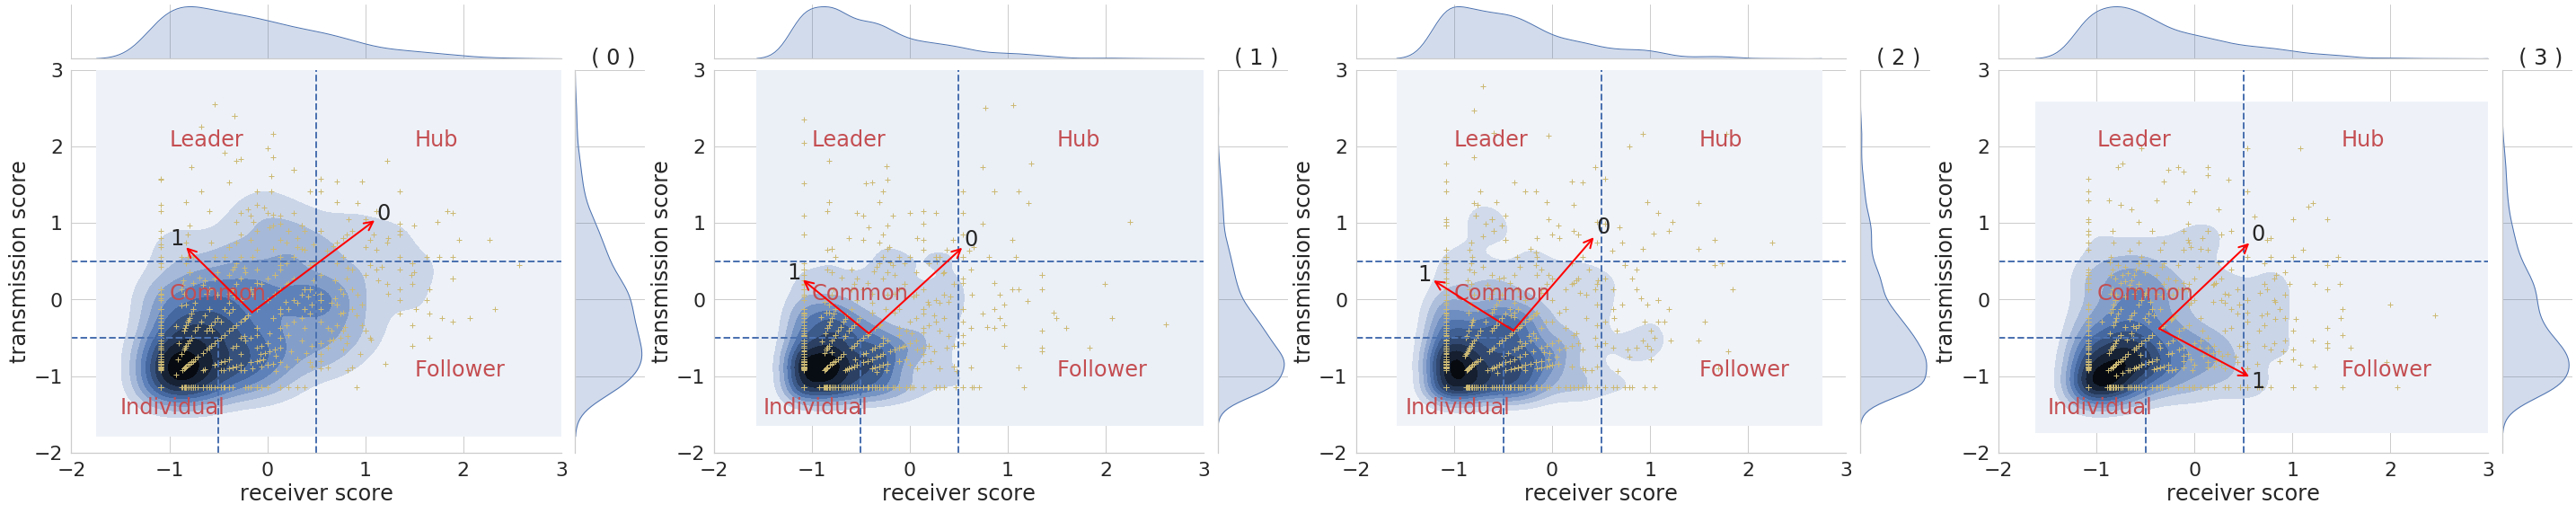

3
cycle: 4, length: 0.655416674010631, ratio: 0.5924410772325599, degree: 49.20657724266813, comp_idx:0
cycle: 4, length: 0.45088182418305583, ratio: 0.40755892276744016, degree: -40.79342275733187, comp_idx:1
cycle: 5, length: 0.8207657820316957, ratio: 0.6515446489287569, degree: 42.948503459138585, comp_idx:0
cycle: 5, length: 0.43895722142043203, ratio: 0.3484553510712432, degree: 132.94850345913858, comp_idx:1
cycle: 6, length: 0.8290425768354037, ratio: 0.6057875811710683, degree: 48.081884691340896, comp_idx:0
cycle: 6, length: 0.5394941885316805, ratio: 0.39421241882893177, degree: -41.918115308659104, comp_idx:1
cycle: 7, length: 0.9953032172888432, ratio: 0.6378877407019931, degree: 43.43124758789143, comp_idx:0
cycle: 7, length: 0.5650077179762174, ratio: 0.362112259298007, degree: 133.43124758789142, comp_idx:1


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

<Figure size 432x288 with 0 Axes>

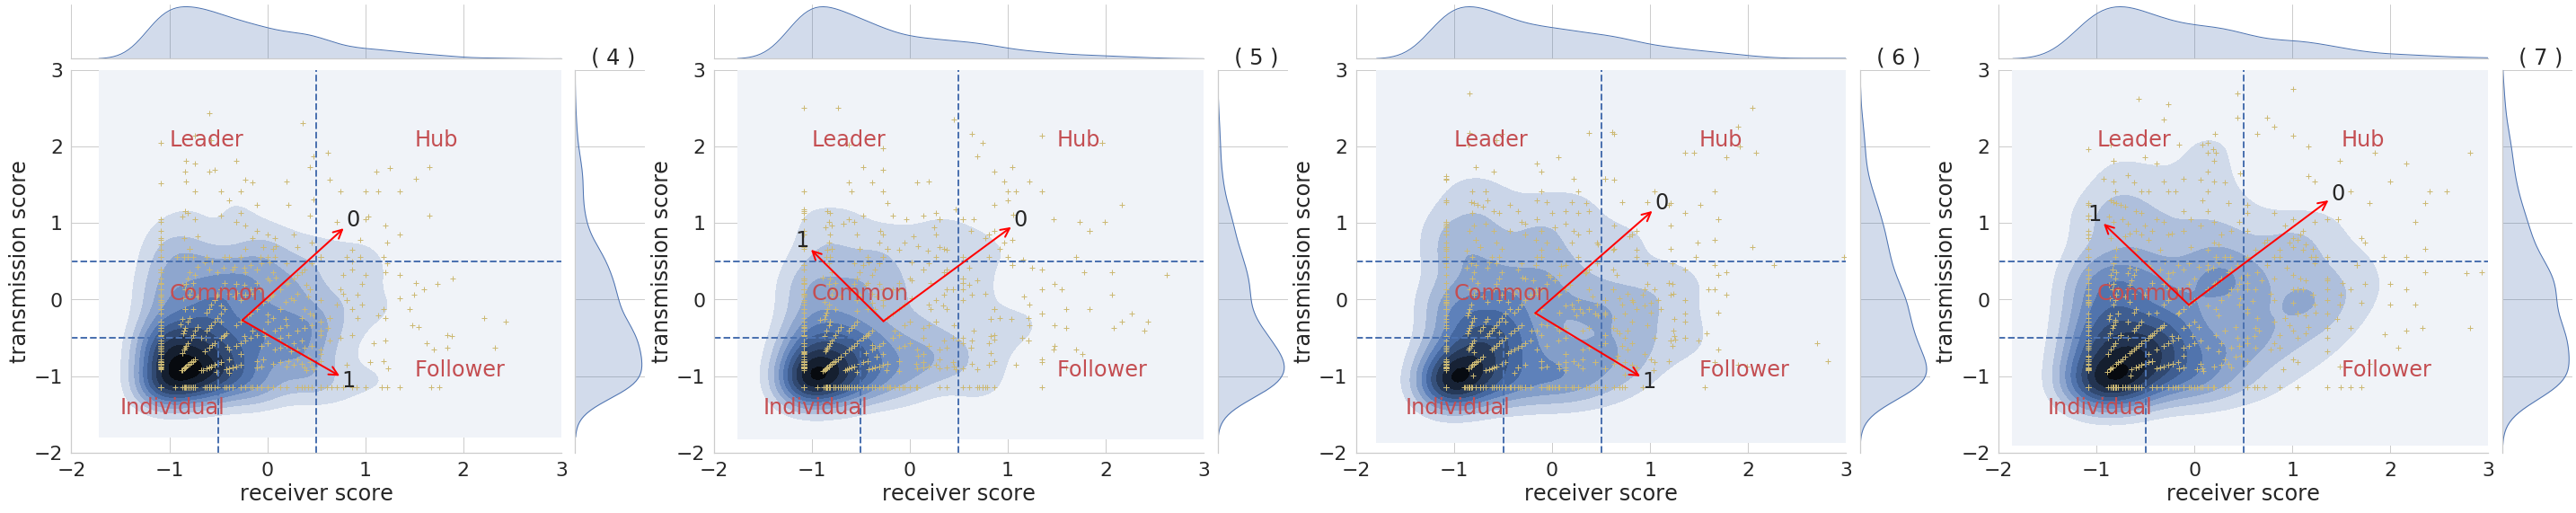

3
cycle: 8, length: 1.0730135325693946, ratio: 0.6080846350312141, degree: 38.626963358509336, comp_idx:0
cycle: 8, length: 0.6915657229388702, ratio: 0.391915364968786, degree: -51.37303664149067, comp_idx:1
cycle: 9, length: 1.0469728236635467, ratio: 0.5972555008395328, degree: 40.81788773453648, comp_idx:0
cycle: 9, length: 0.706000271087139, ratio: 0.4027444991604671, degree: 130.81788773453647, comp_idx:1
cycle: 10, length: 1.2079888913486505, ratio: 0.5642320294273254, degree: 41.671797877648935, comp_idx:0
cycle: 10, length: 0.9329546005951058, ratio: 0.43576797057267447, degree: 131.67179787764894, comp_idx:1
cycle: 11, length: 1.3224472987485132, ratio: 0.5914757473499385, degree: 34.0258632621635, comp_idx:0
cycle: 11, length: 0.9133963595479365, ratio: 0.4085242526500614, degree: 124.0258632621635, comp_idx:1


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

<Figure size 432x288 with 0 Axes>

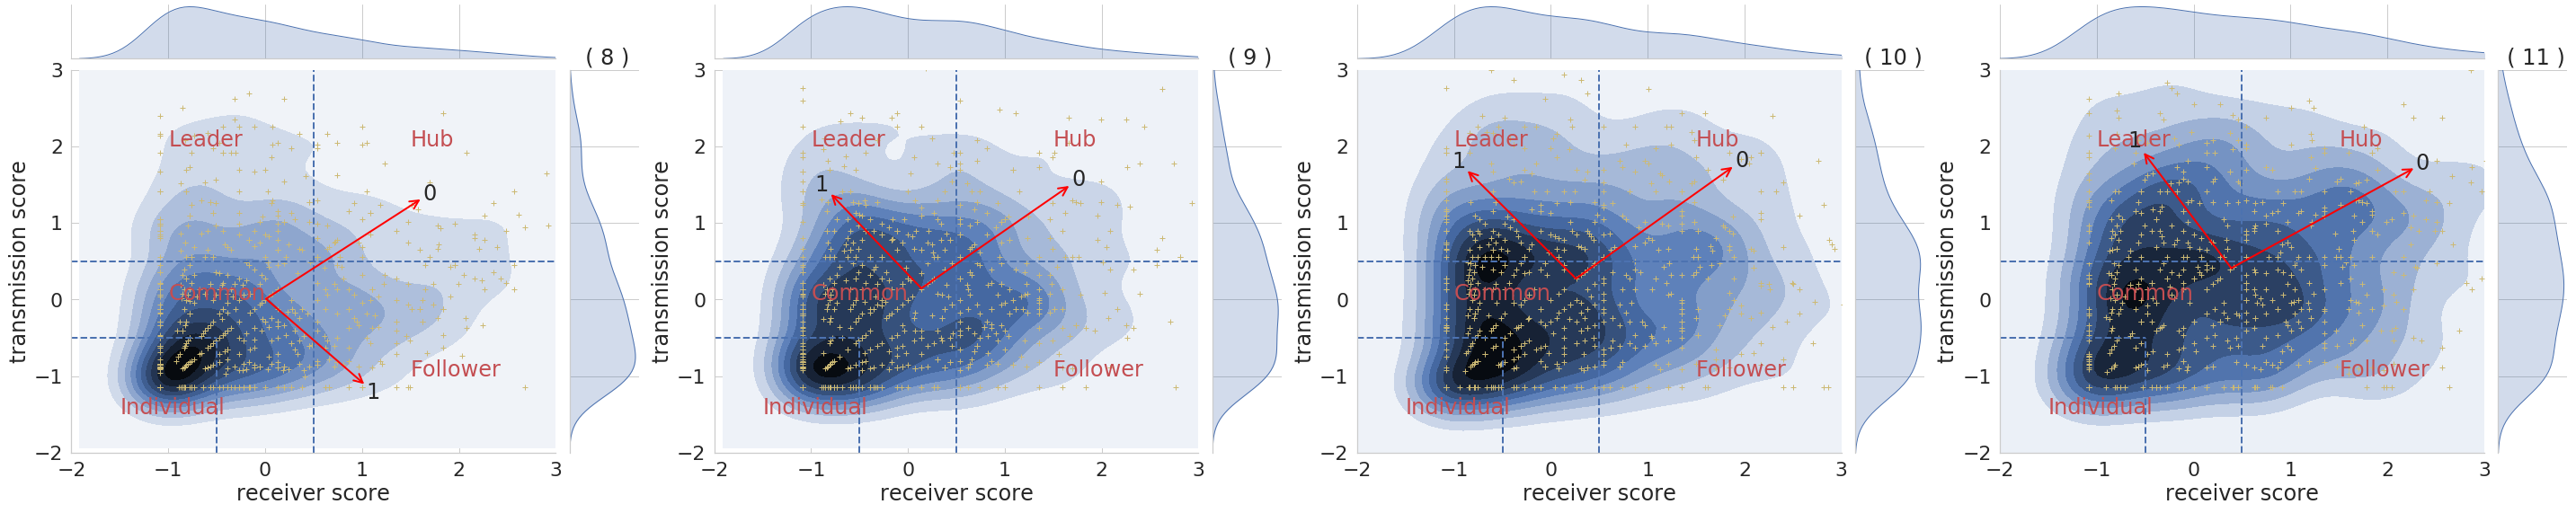

<Figure size 432x288 with 0 Axes>

In [288]:
from sklearn.decomposition import PCA
import math
from module.plothelpers import SeabornFig2Grid as sfg
import matplotlib.gridspec as gridspec
import math

def draw_vector(v0, v1, ax=None, text=''):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='<-',
                    linewidth=2,
                    shrinkA=0, shrinkB=0, color='red')
    ax.annotate(text, v0, v1, arrowprops=arrowprops)

def print_2d_dist(base_path_artifacts, cut, df, cycle_start=0, cycle_end=None, cycle_div_factor = 4):
    idx = pd.IndexSlice
    sns.set(style='whitegrid', font_scale = 2, rc={"lines.linewidth": 1})
    cycles = len(df.index.levels[1])
    
    cycle_end = cycle if cycle_end is None else cycle_end
    
    axis_lim = [-2, 3]
    
    fig = plt.figure(figsize=(40, 8))
    
    print(math.ceil((cycle_end - cycle_start) / cycle_div_factor))
    
    gs = gridspec.GridSpec(1, math.ceil((cycle_end - cycle_start) / cycle_div_factor) + 1)
    
    for cycle_index in range(cycle_start, cycle_end + 1, cycle_div_factor):   
        g = sns.jointplot(x="gc_in", y="gc_out", 
                          data=df.loc[idx[:, [cycle_index, cycle_index]], ['gc_in', 'gc_out']], kind="kde",
                         xlim=axis_lim,
                         ylim=axis_lim, cbar=True, shade_lowest=True)\
                    .plot_joint(plt.scatter, c="y", s=30, linewidth=1, marker="+")\
                    .set_axis_labels("receiver score", "transmission score")
        
        g.ax_joint.plot([cut,cut], axis_lim, 'b--', linewidth = 2)
        g.ax_joint.plot(axis_lim ,[cut,cut], 'b--', linewidth = 2)
        g.ax_joint.plot([-cut,-cut], [axis_lim[0],-cut], 'b--', linewidth = 2)
        g.ax_joint.plot([axis_lim[0],-cut] ,[-cut,-cut], 'b--', linewidth = 2)
        g.ax_joint.text(-1,2,'Leader', color="r")
        g.ax_joint.text(1.5,-1,'Follower', color="r")
        g.ax_joint.text(1.5,2,'Hub', color="r")
        g.ax_joint.text(-1.5,-1.5,'Individual', color="r")
        g.ax_joint.text(-1,0,'Common', color="r")
                
        pca = PCA(n_components=2)
        pca.fit(df.loc[idx[:, [cycle_index, cycle_index]], ['gc_in', 'gc_out']])
        
        for comp_idx, length, ratio, vector in zip(list(range(0, len(pca.components_))),
                                                   pca.explained_variance_, 
                                                   pca.explained_variance_ratio_,
                                                   pca.components_):
            v = vector * 2 * np.sqrt(length)
            degree =  math.degrees(math.atan2((pca.mean_ + v)[1]-(pca.mean_)[1], (pca.mean_ + v)[0]-(pca.mean_)[0]))
            print(f'cycle: {cycle_index}, length: {length}, ratio: {ratio}, degree: {degree}, comp_idx:{comp_idx}')            
            draw_vector(pca.mean_, pca.mean_ + v, ax=g.ax_joint, text=str(comp_idx))
        
        plt.title("  ( " +  str(cycle_index) + " ) ", x=1.10)
    
        sfg(g, fig, gs[(int)((cycle_index - cycle_start) / cycle_div_factor)])
    
    gs.tight_layout(fig, pad=0.4, w_pad=0, h_pad=1.0)
    #gs.update(top=6)
    
    fig.savefig(base_path_artifacts + str(cycle_start) + '_2d_roles_dist_over_time.png')
    plt.savefig(base_path_artifacts + str(cycle_start) + '2d_roles_dist_over_time.eps', format='eps')
    plt.show()
    plt.clf()
    plt.close(fig)    

print_2d_dist(base_path_artifacts, 
              0.5, 
              pd.DataFrame(transformed_norm_df, index=analyze_cell_stats_flat.index, columns=analyze_cell_stats_flat[['gc_in','gc_out']].columns), 
              cycle_start=0, 
              cycle_end=3, 
              cycle_div_factor=1)

print_2d_dist(base_path_artifacts, 
              0.5, 
              pd.DataFrame(transformed_norm_df, index=analyze_cell_stats_flat.index, columns=analyze_cell_stats_flat[['gc_in','gc_out']].columns), 
              cycle_start=4, 
              cycle_end=7, 
              cycle_div_factor=1)

print_2d_dist(base_path_artifacts, 
              0.5, 
              pd.DataFrame(transformed_norm_df, index=analyze_cell_stats_flat.index, columns=analyze_cell_stats_flat[['gc_in','gc_out']].columns), 
              cycle_start=8, 
              cycle_end=11, 
              cycle_div_factor=1)

## PCA

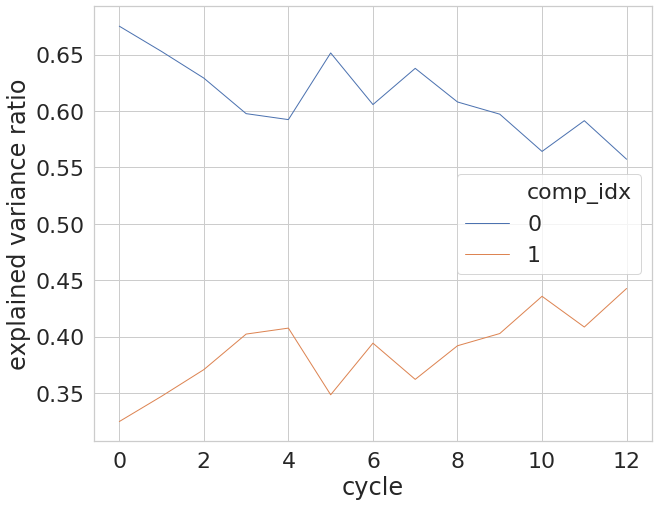

In [289]:
component_data = pd.DataFrame(columns=['cycle', 'comp_idx', 'explained variance ratio', 'degree'])

for cycle_idx in range(0, 13):
    pca = PCA(n_components=2)
    pca.fit(pd.DataFrame(transformed_norm_df, index=analyze_cell_stats_flat.index, columns=analyze_cell_stats_flat[['gc_in','gc_out']].columns).unstack()[[('gc_in', cycle_idx), ('gc_out', cycle_idx)]])
    
    for comp_idx, length, vector in zip(list(range(0, len(pca.components_))) ,pca.explained_variance_ratio_, pca.components_):
        degree =  math.degrees(math.atan2((pca.mean_ + v)[1]-(pca.mean_)[1], (pca.mean_ + v)[0]-(pca.mean_)[0]))
        
        component_data = component_data.append({'cycle': int(cycle_idx),
                                                'comp_idx': int(comp_idx),
                                                'explained variance ratio': length,
                                                'degree': degree}, ignore_index=True)

component_data = component_data.astype({
                                'cycle': int,
                                'comp_idx': int
                            })

fig = plt.figure(figsize=(10, 8))

sns.lineplot(data=component_data, x='cycle', y='explained variance ratio', hue='comp_idx')

plt.show()

In [220]:
pca.singular_values_

array([22.54842482, 15.63624423])

In [221]:
pca.components_

array([[ 0.72577248,  0.68793481],
       [-0.68793481,  0.72577248]])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


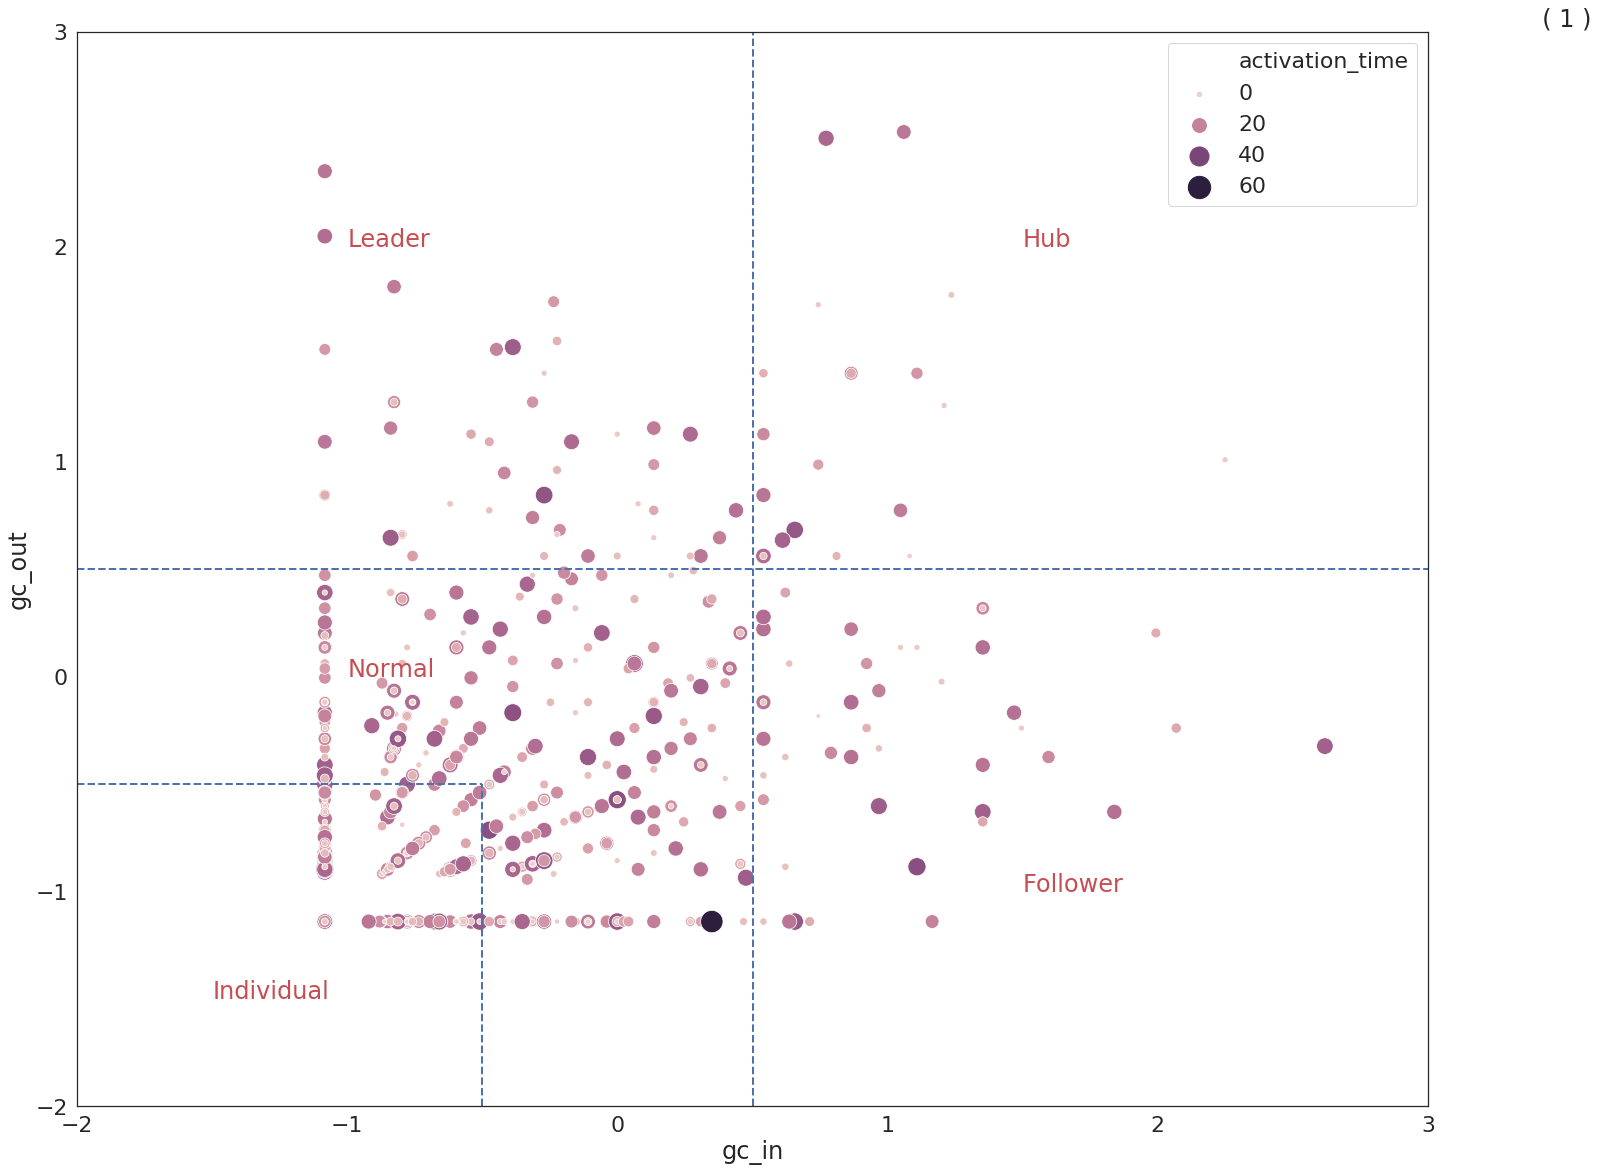

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

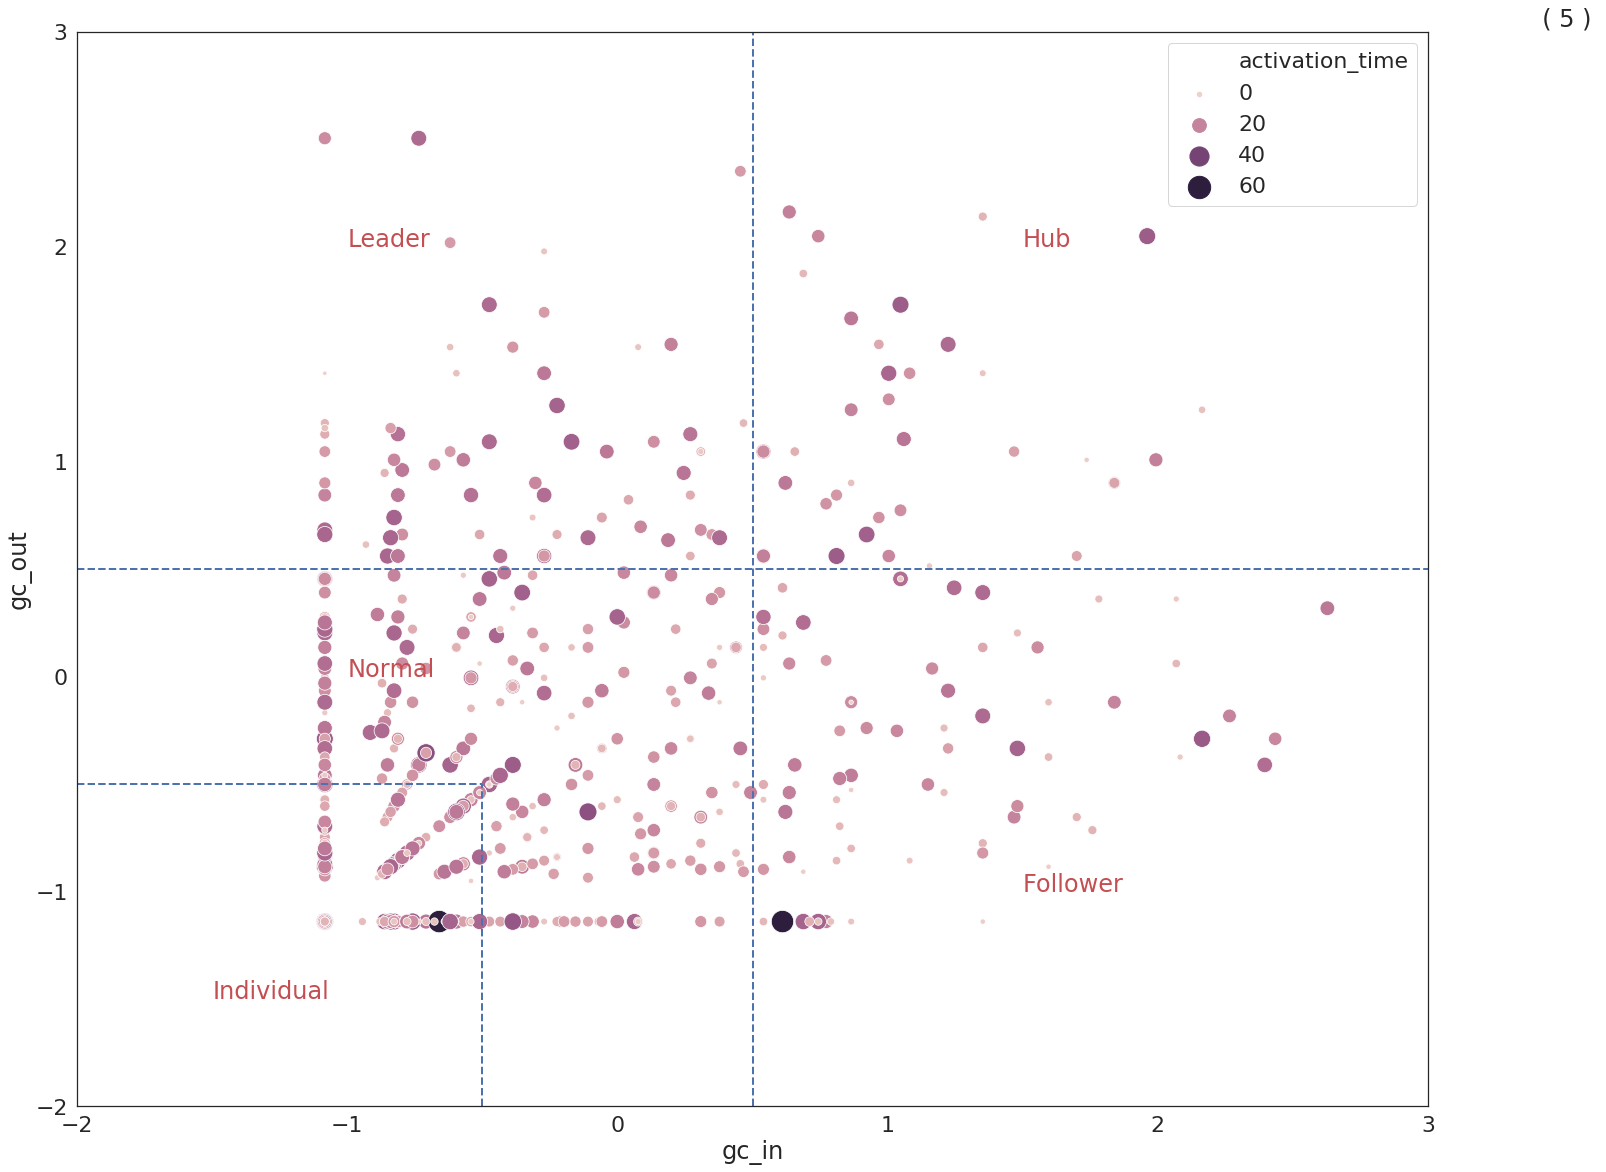

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [927]:
from module.plothelpers import SeabornFig2Grid as sfg
import matplotlib.gridspec as gridspec
import math

def print_2d_dist(base_path_artifacts, cut, df):
    idx = pd.IndexSlice
    sns.set(style='white', font_scale = 2, rc={"lines.linewidth": 1})
    cycles = len(df.index.levels[1]) - 1
    
    axis_lim = [-2, 3]
    
    cycle_div_factor = 4
    
    for cycle_index in range(1, cycles, cycle_div_factor):
        fig, ax = plt.subplots(figsize=(20, 16))
        
        g = sns.scatterplot(x="gc_in", y="gc_out", 
                       data=df.loc[idx[:, [cycle_index, cycle_index]], ['gc_in', 'gc_out','activation_time']], 
                       hue='activation_time', legend="brief", size='activation_time', sizes=(20, 500))
                        #.set_axis_labels("receiver score", "transmission score")
                        #.plot_joint(plt.scatter, c="y", s=30, linewidth=1, marker="+")\
                
        #outpathc = g.get_children()[3] 

        #plt.colorbar(mappable=outpathc)
        
        g.plot([cut,cut], axis_lim, 'b--', linewidth = 2)
        g.plot(axis_lim ,[cut,cut], 'b--', linewidth = 2)
        g.plot([-cut,-cut], [axis_lim[0],-cut], 'b--', linewidth = 2)
        g.plot([axis_lim[0],-cut] ,[-cut,-cut], 'b--', linewidth = 2)
        g.text(-1,2,'Leader', color="r")
        g.text(1.5,-1,'Follower', color="r")
        g.text(1.5,2,'Hub', color="r")
        g.text(-1.5,-1.5,'Individual', color="r")
        g.text(-1,0,'Common', color="r")
        
        plt.tight_layout(pad=0.4, w_pad=2, h_pad=1.0)
        ax.set_xlim(axis_lim)
        ax.set_ylim(axis_lim)
        
        plt.title("  ( " +  str(cycle_index) + " ) ", x=1.10)
        
        fig.savefig(base_path_artifacts + '2d_activation_time_dist_over_time_' + str(cycle_index) + '.png')
        plt.savefig(base_path_artifacts + '2d_activation_time_dist_over_time_' + str(cycle_index) + '.eps', format='eps')  
        
        plt.show()
        plt.clf()
        plt.close(fig)    
    
        #sfg(g, fig, gs[(int)(cycle_index / cycle_div_factor)])
    
    #gs.tight_layout(fig, pad=0.4, w_pad=2, h_pad=1.0)
    #gs.update(top=6)
    
    #fig.savefig(base_path_artifacts + '2d_roles_dist_over_time.png')
    #plt.savefig(base_path_artifacts + '2d_roles_dist_over_time.eps', format='eps')  

print_2d_dist(base_path_artifacts, 0.5, 
             pd.DataFrame(np.hstack((transformed_norm_df, analyze_cell_stats_flat['activation_time'].values.reshape(-1 , 1))), index=analyze_cell_stats_flat.index, columns=analyze_cell_stats_flat[['gc_in','gc_out', 'activation_time']].columns))

## Movie of 2D Roles

In [928]:
def make_movie_2d_dist(base_path_artifacts, cut, df, cycles):
    idx = pd.IndexSlice
    sns.set(style='white', font_scale = 2, rc={"lines.linewidth": 1})
    axis_lim = [-2, 3]
    
    def get_data(df, cycle_index):
        return df.loc[idx[:, [cycle_index, cycle_index]], ['gc_in', 'gc_out']]
    
    def prep_axes(g, xlim, ylim):
        g.ax_joint.clear()
        g.ax_joint.set_xlim(xlim)
        g.ax_joint.set_ylim(ylim)
        g.ax_marg_x.clear()
        g.ax_marg_x.set_xlim(xlim)
        g.ax_marg_y.clear()
        g.ax_marg_y.set_ylim(ylim)        
        plt.setp(g.ax_marg_x.get_xticklabels(), visible=False)
        plt.setp(g.ax_marg_y.get_yticklabels(), visible=False)
        plt.setp(g.ax_marg_x.yaxis.get_majorticklines(), visible=False)
        plt.setp(g.ax_marg_x.yaxis.get_minorticklines(), visible=False)
        plt.setp(g.ax_marg_y.xaxis.get_majorticklines(), visible=False)
        plt.setp(g.ax_marg_y.xaxis.get_minorticklines(), visible=False)
        plt.setp(g.ax_marg_x.get_yticklabels(), visible=False)
        plt.setp(g.ax_marg_y.get_xticklabels(), visible=False)
                      
    # Build plot
    fig = plt.figure(figsize=(10,10))
    
    g = sns.JointGrid(x=get_data(df, 0)['gc_in'], y=get_data(df, 0)['gc_out'])
    
    def plot_roles_grid(ax, cycle_index):
        ax.plot([cut,cut], axis_lim, 'b--', linewidth = 2)
        ax.plot(axis_lim ,[cut,cut], 'b--', linewidth = 2)
        ax.plot([-cut,-cut], [axis_lim[0],-cut], 'b--', linewidth = 2)
        ax.plot([axis_lim[0],-cut] ,[-cut,-cut], 'b--', linewidth = 2)
        ax.text(-2,2.8,'leader', color="r")
        ax.text(1.3,-2,'follower', color="r")
        ax.text(1.3,2.8,'hub', color="r")
        ax.text(-2,-2,'individual', color="r")
        ax.text(-1,0,'common', color="r")

    def update(cycle_index):
        if cycle_index >= cycles:
            cycle_index = cycles - (cycle_index - (cycles - 2))
        data = get_data(df, cycle_index)
        g.x = data['gc_in']
        g.y = data['gc_out']
        prep_axes(g, axis_lim, axis_lim)
        g.plot_joint(sns.kdeplot, legend=False)
        g.plot_joint(plt.scatter, c="y", s=30, linewidth=1, marker="+")
        g.plot_marginals(sns.kdeplot, color="m", shade=True, legend=False)
        g.set_axis_labels("Receiver score", "Transmission score")
        
        plot_roles_grid(g.ax_joint, cycle_index)
        plt.title("C: %d"%(cycle_index), fontweight="bold")
        
    anim = animation.FuncAnimation(g.fig, update, frames=cycles, interval=500, repeat=True)
    
    anim.save(base_path_artifacts + '_2d_dist_movie.mp4')

    return HTML(anim.to_html5_video())

In [929]:
make_movie_2d_dist(base_path_artifacts, 
                   0.5, 
                   pd.DataFrame(transformed_norm_df, 
                                index=analyze_cell_stats_flat.index, 
                                columns=analyze_cell_stats_flat[['gc_in','gc_out']].columns), 13)

<Figure size 720x720 with 0 Axes>

## 2D Heatmap Roles Distribution

In [930]:
from module.plothelpers import SeabornFig2Grid as sfg
import matplotlib.gridspec as gridspec
import math

def unifi_color_map(vmin, vmax):
    import matplotlib as mpl
    
    norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
    
    return norm

def print_2d_heatmap(base_path_artifacts, cut, df):    
    idx = pd.IndexSlice
    #sns.set(style='whitegrid', font_scale = 2, rc={"lines.linewidth": 1})
    cycles = len(df.index.levels[1]) - 1
    
    axis_lim = [-2, 3]
    
    cycle_div_factor = 4
    
    bins = np.linspace(-2, 3, num=25)
    
    maximum_value_bin = 0.0
    
    #get maximum.minimum value
    for cycle_index in range(0, cycles, cycle_div_factor):
        cycle_data = df.loc[idx[:, [cycle_index, cycle_index]], ['gc_in', 'gc_out']]
        h, xed, yed = np.histogram2d(x=cycle_data['gc_in'],y=cycle_data['gc_out'], bins=bins)
        maximum_value_bin = max(maximum_value_bin, np.max(h))
        
    norm = unifi_color_map(vmin=1, vmax=maximum_value_bin)
    
    
    fig, ax = plt.subplots(figsize=(40, 8), ncols=math.ceil(cycles / cycle_div_factor), nrows=1 , sharey=True)
    
    #color_map_hist = plt.cm.jet
    #color_map_hist.set_under('w',0)
    
    for cycle_index in range(0, cycles, cycle_div_factor):
        cycle_data = df.loc[idx[:, [cycle_index, cycle_index]], ['gc_in', 'gc_out']]        
        
        plot_index = (int)(cycle_index / cycle_div_factor)
        
        g = ax[plot_index].hist2d(x=cycle_data['gc_in'],y=cycle_data['gc_out'], bins=(bins, bins), cmap='Blues', norm=norm)
        
        ax[plot_index].plot([cut,cut], axis_lim, 'b--', linewidth = 2)
        ax[plot_index].plot(axis_lim ,[cut,cut], 'b--', linewidth = 2)
        ax[plot_index].plot([-cut,-cut], [axis_lim[0],-cut], 'b--', linewidth = 2)
        ax[plot_index].plot([axis_lim[0],-cut] ,[-cut,-cut], 'b--', linewidth = 2)
        ax[plot_index].text(-1,2,'Leader', color="r")
        ax[plot_index].text(1.5,-1,'Follower', color="r")
        ax[plot_index].text(1.5,2,'Hub', color="r")
        ax[plot_index].text(-1.5,-1.5,'Individual', color="r")
        ax[plot_index].text(-1,0,'Common', color="r")
        
        #plt.title("  ( " +  str(cycle_index) + " ) ", x=1.10)
    
    #fig.colorbar(ax[1].collections[0], cax=ax[2])
        
    plt.colorbar(g[3], ax=ax[(int)(cycles / cycle_div_factor)])
    plt.tight_layout()
    
    fig.savefig(base_path_artifacts + '2d_roles_2d_heatmap_over_time.png')
    plt.clf()
    plt.close(fig)

print_2d_heatmap(base_path_artifacts, 0.5, pd.DataFrame(transformed_norm_df, index=analyze_cell_stats_flat.index, columns=analyze_cell_stats_flat[['gc_in','gc_out']].columns))

## Roles Over Time

In [115]:
def transition_matrix(data):
    number_of_states = data.values.max() + 1
    
    M = np.zeros((number_of_states, number_of_states))
    
    for node_idx in range(data.shape[1]):
        for (i,j) in zip(data.iloc[:, node_idx], data.iloc[1:, node_idx]):
            M[i][j] += 1

    #now convert to probabilities:
    for row in M:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    return M

def distribution_cell_states(cell_states):
    return cell_states / sum(cell_states)

def plot_frequency_of_roles(base_path_artifacts, analyze_cell_stats_flat, threshold_i=0.5):
    state_matrix = analyze_cell_stats_flat.unstack()['Manual_' + str(threshold_i)].transpose()
    
    ## frequency_of_roles
    unique_elements, counts_elements = np.unique(state_matrix.values.flatten(), return_counts=True)

    sns.set(style='whitegrid', font_scale = 2, rc={"lines.linewidth": 4})

    fig, ax = plt.subplots(figsize=(12,6))
    plt.title('Threshold ' + str(threshold_i))
    ax = sns.barplot(x=unique_elements, y=counts_elements / sum(counts_elements))
    plt.ylabel('Frequency')
    plt.xlabel('Cluster')
    
    fig.savefig(base_path_artifacts + 'frequency_of_roles.png')
    plt.clf()
    plt.close(fig)

def plot_roles_lines_over_time(base_path_artifacts, analyze_cell_stats_flat, cycles, threshold_i=0.5):
    import scipy.stats as stats
    state_matrix = analyze_cell_stats_flat.unstack()['Manual_' + str(threshold_i)].transpose()

    ## frequency_of_roles
    unique_elements, counts_elements = np.unique(state_matrix.values.flatten(), return_counts=True)
    
    ## Frequency mode during time
    state_matrix_pp = state_matrix.transpose().apply(lambda cell_states:                               
                                   np.bincount(cell_states, minlength=len(unique_elements)), 
                               axis=0)

    state_matrix_pp = state_matrix_pp.round(2).apply(lambda cell_states: distribution_cell_states(cell_states), axis=0).round(2)
    
    state_matrix_pp_t = state_matrix_pp.transpose()
    
    state_matrix_pp_t = state_matrix_pp_t.rename(columns={0: transle_role(0), 
                                                          1: transle_role(1), 
                                                          2: transle_role(2),
                                                          3: transle_role(3),
                                                          4: transle_role(4)})
    
    state_matrix_pp_t['Cycle'] = state_matrix_pp_t.index.astype(int)
    
    state_matrix_pp_t = state_matrix_pp_t[state_matrix_pp_t['Cycle'] < cycles]
    
    #plot roles
    state_matrix_pp_t_melt = pd.melt(state_matrix_pp_t, id_vars=['Cycle'], value_vars=['Hub', 'Individual', 'Follower', 'Leader', 'Common'],
                               var_name='Role', value_name='Portion')
    
    print(state_matrix_pp_t_melt)
    
    sns.set(style='whitegrid', font_scale = 2, rc={"lines.linewidth": 2})

    fig, ax = plt.subplots(figsize=(12,8))
    ax = sns.pointplot(ax=ax, x='Cycle', y='Portion', hue='Role' ,data=state_matrix_pp_t_melt[state_matrix_pp_t_melt['Cycle'] < cycles], legend=True)
    
    fig.savefig(base_path_artifacts + 'roles_lines_over_time.png')
    fig.savefig(base_path_artifacts + 'roles_lines_over_time.eps', format='eps')
    plt.show()
    plt.clf()
    plt.close(fig)
    
    sns.set(style='white', font_scale = 1.5, rc={"lines.linewidth": 3})
        
    #plot p(leader) * p(follower) vs p(hub)    
    state_matrix_pp_t['P(Leader+Hub)*P(Follower+Hub)'] = (state_matrix_pp_t['Follower'] + state_matrix_pp_t['Hub'])*(state_matrix_pp_t['Leader']+state_matrix_pp_t['Hub'])

    fig, ax = plt.subplots(figsize=(8,8))
    ax = sns.scatterplot(ax=ax, x='P(Leader+Hub)*P(Follower+Hub)', y='Hub', hue='Cycle', data=state_matrix_pp_t, s=100, palette=sns.color_palette('spring', state_matrix_pp_t.shape[0]))
    
    ticks_range = np.arange(0.0, 0.5, step=0.1)
    
    ax.set(xlim=(0.0, 0.3), ylim=(0.0, 0.3), xticks=ticks_range, yticks=ticks_range)
    
    plt.plot(ticks_range, ticks_range, 'r--')
    
    data_correlation = stats.pearsonr(x=state_matrix_pp_t['P(Leader+Hub)*P(Follower+Hub)'], 
                                  y=state_matrix_pp_t['Hub'])

    ax.annotate("n={}, coefficient = {:.4f}, p = {:.4f}".format(len(state_matrix_pp_t),
                data_correlation[0], data_correlation[1]), 
                xy=(.3, .9), xycoords=ax.transAxes, fontsize=11)
    
    from scipy.stats import wilcoxon
    
    ax.annotate("wilcoxon p = {:.4f}".format(wilcoxon(state_matrix_pp_t['P(Leader+Hub)*P(Follower+Hub)'],
                                                state_matrix_pp_t['Hub'])[1]),
                xy=(.3, .6), xycoords=ax.transAxes, fontsize=11)
    
    plt.tight_layout(pad=0.4, w_pad=2, h_pad=1.0)

    
    fig.savefig(base_path_artifacts + 'roles_leadership_followership_vs_hub.png')
    plt.savefig(base_path_artifacts + 'roles_leadership_followership_vs_hub.eps', format='eps')
    plt.show()
    plt.clf()
    plt.close(fig)
    
    #plot p(leader) vs p(follower)    
    sns.set(style='whitegrid', font_scale = 2, rc={"lines.linewidth": 4})

    fig, ax = plt.subplots(figsize=(12,6))
    ax = sns.scatterplot(ax=ax, x='Follower', y='Leader' ,data=state_matrix_pp_t, s=100)
    
    ticks_range = np.arange(0.0, 0.5, step=0.1)
    
    ax.set(xlim=(0.0, 0.4), ylim=(0.0, 0.4), xticks=ticks_range, yticks=ticks_range)
    
    fig.savefig(base_path_artifacts + 'roles_leadership_vs_followership.png')
    plt.clf()
    plt.close(fig)

def plot_transition_matrix_heatmap(base_path_artifacts, suffix, df):
    sns.set(style='white', font_scale = 1, rc={"lines.linewidth": 1})
    
    roles_list = [transle_role(x) for x in range(5)]
    fig, ax = plt.subplots()
    ax = sns.heatmap(pd.DataFrame(df, index=roles_list, columns=roles_list) , annot=True, cmap="YlGnBu", vmin=0)
    plt.tight_layout(pad=0.4, w_pad=2, h_pad=1.0)
    fig.savefig(base_path_artifacts + 'transition_matrix_heatmap_' + suffix + '.png')
    plt.savefig(base_path_artifacts + 'transition_matrix_heatmap_.' + suffix + '.eps', format='eps')
    plt.title('transition_matrix_heatmap_' + suffix)
    plt.show()
    plt.clf()
    plt.close(fig)
    
def calc_stat_dist(transition_matrix):
    'https://stackoverflow.com/questions/31791728/python-code-explanation-for-stationary-distribution-of-a-markov-chain'
    Q = transition_matrix
    
    #We have to transpose so that Markov transitions correspond to right multiplying by a column vector.  np.linalg.eig finds right eigenvectors.
    evals, evecs = np.linalg.eig(Q.T)
    evec1 = evecs[:,np.isclose(evals, 1)]

    #Since np.isclose will return an array, we've indexed with an array
    #so we still have our 2nd axis.  Get rid of it, since it's only size 1.
    evec1 = evec1[:,0]

    stationary = evec1 / evec1.sum()

    #eigs finds complex eigenvalues and eigenvectors, so you'll want the real part.
    stationary = stationary.real
    
    print(stationary)
    print(stationary.dot(Q))
    
def plot_transition_matrix(base_path_artifacts, analyze_cell_stats_flat, upper_bound_cycle, threshold_i=0.5):
    state_matrix = analyze_cell_stats_flat.unstack()['Manual_' + str(threshold_i)].transpose()

    ## frequency_of_roles
    unique_elements, counts_elements = np.unique(state_matrix.values.flatten(), return_counts=True)
    
    pd.DataFrame(transition_matrix(state_matrix.iloc[:upper_bound_cycle, :])).to_excel(base_path_artifacts + "transition_matrix.xlsx")
    
    calc_stat_dist(transition_matrix(state_matrix.iloc[:upper_bound_cycle, :]))
    
    global_frequency_matrix = counts_elements / sum(counts_elements)
    
    expected_frequency_matrix = np.outer(global_frequency_matrix,global_frequency_matrix)
    
    print(global_frequency_matrix)
    
    print(expected_frequency_matrix)
    
    expected_frequency_matrix /= global_frequency_matrix[:, None]
    
    print(expected_frequency_matrix)
    
    #pd.DataFrame(transition_matrix(state_matrix.iloc[:-1, :])).to_excel(base_path_artifacts + "transition_matrix_without_last_cycle.xlsx")
    
    #plot_transition_matrix_heatmap(base_path_artifacts, 'without_last_cycle', transition_matrix(state_matrix.iloc[:-1, :]))
    
    plot_transition_matrix_heatmap(base_path_artifacts, str(0) + ':' + str(upper_bound_cycle - 1), transition_matrix(state_matrix.iloc[:upper_bound_cycle, :]))
    
    plot_transition_matrix_heatmap(base_path_artifacts, 'equilibrium state', expected_frequency_matrix)
    
    plot_transition_matrix_heatmap(base_path_artifacts, 'divide_by_equilibrium state ' +  str(0) + ':' + str(upper_bound_cycle - 1), 
                                   np.divide(transition_matrix(state_matrix.iloc[:upper_bound_cycle, :]), expected_frequency_matrix))
    
    return np.divide(transition_matrix(state_matrix.iloc[:upper_bound_cycle, :]), expected_frequency_matrix)
    
    #for cycle_i in range(0, upper_bound_cycle - 1):
    #    plot_transition_matrix_heatmap(base_path_artifacts, str(cycle_i) + ':' + str(cycle_i + 1), transition_matrix(state_matrix.iloc[cycle_i:cycle_i+2, :]))
    
    
def plot_transition_matrix_normalize(base_path_artifacts, analyze_cell_stats_flat, upper_bound_cycle, threshold_i=0.5):    
    state_matrix = analyze_cell_stats_flat.unstack()['Manual_' + str(threshold_i)].transpose()

    ## frequency_of_roles
    unique_elements, counts_elements = np.unique(state_matrix.values.flatten(), return_counts=True)
    
    frequency_of_roles = counts_elements / sum(counts_elements)
    
    #pd.DataFrame(transition_matrix(state_matrix.iloc[:-1, :]) / frequency_of_roles).to_excel(base_path_artifacts + "transition_matrix_normalize_without_last_cycle.xlsx")
    
    pd.DataFrame(transition_matrix(state_matrix.iloc[:upper_bound_cycle, :])/ frequency_of_roles).to_excel(base_path_artifacts + "transition_matrix_normalize.xlsx")
    
    #plot_transition_matrix_heatmap(base_path_artifacts, 'without_last_cycle_normalize', transition_matrix(state_matrix.iloc[:-1, :]) / frequency_of_roles)
    plot_transition_matrix_heatmap(base_path_artifacts, 'normalize', transition_matrix(state_matrix.iloc[:, :])/ frequency_of_roles)
    

def plot_roles_lines_over_time_i(base_path_artifacts, analyze_cell_stats_flat, threshold_i=0.5):
    state_matrix = analyze_cell_stats_flat.unstack()['Manual_' + str(threshold_i)]
    
    state_matrix = state_matrix.iloc[:, 0]
    
    state_matrix[state_matrix != 0] = -1
    
    print(state_matrix)
    
#non_equilibrium_state_vs_equilibrium_state_matrix = plot_transition_matrix(base_path_artifacts, analyze_cell_stats_flat, 13)
#plot_transition_matrix_normalize(base_path_artifacts, analyze_cell_stats_flat, 13)
plot_roles_lines_over_time(base_path_artifacts, analyze_cell_stats_flat, 13)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [116]:
sns.__version__

'0.10.0'

# Transition Matrix Network X

In [49]:
non_equilibrium_state_vs_equilibrium_state_matrix

array([[2.41521342, 1.47349356, 1.36266311, 0.6125591 , 0.26934439],
       [1.23654676, 1.3696995 , 1.33557473, 0.95125467, 0.50283828],
       [1.08862096, 1.36698354, 1.3504766 , 1.0032269 , 0.50123139],
       [0.45000555, 0.89148967, 0.97469122, 1.27867392, 0.9877735 ],
       [0.23084591, 0.68136127, 0.61503748, 1.24740513, 1.50131978]])

In [103]:
import matplotlib.pyplot as plt
import networkx as nx

vector_names = ['Hub', 'Leader', 'Follower', 'Common', 'Individual']

non_equilibrium_state_vs_equilibrium_state_matrix_dataframe = pd.DataFrame(non_equilibrium_state_vs_equilibrium_state_matrix, 
                          columns=vector_names, index=vector_names)

#extracts the indices from the correlation matrix, which are the stocks
measures = non_equilibrium_state_vs_equilibrium_state_matrix_dataframe.index.values

#Changes from dataframe to matrix, so it is easier to create a graph with networkx
cor_matrix = np.asmatrix(non_equilibrium_state_vs_equilibrium_state_matrix_dataframe)

G = nx.from_numpy_matrix(cor_matrix, create_using=nx.MultiDiGraph)
G = nx.relabel_nodes(G,lambda x: measures[x])
#shows the edges with their corresponding weights
G.edges(data=True)

def create_corr_network_1(G):
    #crates a list for edges and for the weights
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())

    #positions
    positions=nx.circular_layout(G)
    
    print(positions)
    
    #Figure size
    plt.figure(figsize=(8,8))
    
    print(G.nodes())
    colors_map = ['#17202A', '#17202A', '#17202A', '#17202A', '#17202A']

    #draws nodes
    nx.draw_networkx_nodes(G,positions,node_color=colors_map,
                           node_size=300,alpha=1)
    
    #Styling for labels
    nx.draw_networkx_labels(G, dict((key, value + 0.05) for key, value in positions.items()), 
                            font_size=20, 
                            font_family='sans-serif')
        
    #draws the edges
    nx.draw_networkx_edges(G, positions, edge_list=edges,style='solid',
                      ###adds width=weights and edge_color = weights 
                      ###so that edges are based on the weight parameter 
                      ###edge_cmap is for the color scale based on the weight
                      ### edge_vmin and edge_vmax assign the min and max weights for the width
                      width=4, edge_color = weights, edge_cmap = plt.cm.GnBu,
                      edge_vmin = min(weights), edge_vmax=max(weights), 
                      arrows=True, arrowsize=30, connectionstyle='arc3,rad=0.3', 
                      min_source_margin=20, 
                      min_target_margin=20)
    
    sm = plt.cm.ScalarMappable(cmap=plt.cm.GnBu, norm=plt.Normalize(vmin = min(weights), vmax=max(weights)))
    sm._A = []
    plt.colorbar(sm)
    
    plt.tight_layout(pad=1, w_pad=4, h_pad=1.0)
    
    # displays the graph without axis
    plt.axis('off')    
    #saves image
    #plt.savefig(images_eps_base_path + 'measures_corr.eps', format='eps')
    plt.show()

create_corr_network_1(G)

{'Hub': array([1., 0.]), 'Leader': array([0.30901695, 0.95105657]), 'Follower': array([-0.80901706,  0.58778526]), 'Normal': array([-0.809017  , -0.58778532]), 'Individual': array([ 0.3090171 , -0.95105651])}
['Hub', 'Leader', 'Follower', 'Normal', 'Individual']


In [106]:
nx.write_gml(G, base_path_artifacts + 'non_equilibrium_state_vs_equilibrium_state_matrix.gml')

In [105]:
base_path_artifacts

'./artifacts/5-08-Exp2_'

In [933]:
analyze_cell_stats_flat.unstack()['Manual_' + str(0.5)].transpose().iloc[:13, :]

1.0    2.0    3.0    4.0    5.0    6.0    7.0    8.0    9.0    10.0   \
part                                                                         
0.0       1      3      4      3      4      1      3      4      2      3   
1.0       3      3      4      3      3      4      4      4      3      3   
2.0       3      3      1      4      3      3      3      3      3      4   
3.0       3      2      4      3      4      3      4      4      2      4   
4.0       4      3      4      3      4      3      3      2      3      4   
5.0       3      1      1      3      3      4      3      3      4      3   
6.0       3      3      3      4      4      3      4      4      3      4   
7.0       2      1      2      1      3      4      3      2      3      4   
8.0       3      1      3      1      1      3      1      3      4      4   
9.0       2      0      2      4      2      1      2      1      4      2   
10.0      2      1      1      1      1      1      3      3      1      2   
11.0      2      2      0      3      3      4      3      4      4      1   
12.0      2      2      1      3      3      2      1      4      1      3   

      ...  664.0  665.0  666.0  667.0  668.0  669.0  670.0  671.0  672.0  \
part  ...                                                                  
0.0   ...      4      4      3      4      3      3      3      2      3   
1.0   ...      3      4      4      3      3      3      3      4      4   
2.0   ...      4      4      4      3      3      2      4      2      4   
3.0   ...      3      3      4      3      3      3      3      4      3   
4.0   ...      3      1      3      3      4      1      3      3      1   
5.0   ...      4      4      3      4      3      3      2      4      4   
6.0   ...      3      4      2      3      4      3      4      4      3   
7.0   ...      3      3      3      3      4      3      3      3      3   
8.0   ...      3      3      3      3      1      3      3      2      4   
9.0   ...      3      4      3      3      3      2      3      1      4   
10.0  ...      3      2      3      3      1      1      1      3      3   
11.0  ...      3      1      2      2      3      0      2      1      3   
12.0  ...      3      1      1      3      3      3      3      1      3   

      673.0  
part         
0.0       3  
1.0       3  
2.0       4  
3.0       4  
4.0       3  
5.0       3  
6.0       4  
7.0       3  
8.0       4  
9.0       1  
10.0      3  
11.0      3  
12.0      1  

[13 rows x 661 columns]

## Figure 4

### hub/indivdual ratio over cycle

In [934]:
f, axes = plt.subplots(13, 1, figsize=(8, 12), sharex=True, sharey=True)

for cycle in range(0, 13):
    df_tr_re_score_cycle = pd.DataFrame(transformed_norm_df, 
                                    index=analyze_cell_stats_flat.index, 
                                    columns=analyze_cell_stats_flat[['gc_in','gc_out']].columns).loc[pd.IndexSlice[:,cycle:cycle], :]
    df_tr_re_score_cycle = df_tr_re_score_cycle['gc_out'] + df_tr_re_score_cycle['gc_in']
    
    sns.distplot(df_tr_re_score_cycle, ax=axes[cycle])
    axes[cycle].title.set_text('Cycle: ' + str(cycle))

plt.xlim(-4, 9)
plt.tight_layout()

TypeError: 'int' object is not callable

In [ ]:
def plot_hub_indivdual_ratio_over_cycles(base_path_artifacts, analyze_cell_stats_flat, cycles, threshold_i=0.5):
    import scipy.stats as stats
    state_matrix = analyze_cell_stats_flat.unstack()['Manual_' + str(threshold_i)].transpose()

    ## frequency_of_roles
    unique_elements, counts_elements = np.unique(state_matrix.values.flatten(), return_counts=True)
    
    ## Frequency mode during time
    state_matrix_pp = state_matrix.transpose().apply(lambda cell_states:                               
                                   np.bincount(cell_states, minlength=len(unique_elements)), 
                               axis=0)

    state_matrix_pp = state_matrix_pp.round(2).apply(lambda cell_states: distribution_cell_states(cell_states), axis=0).round(2)
    
    state_matrix_pp_t = state_matrix_pp.transpose()
    
    state_matrix_pp_t = state_matrix_pp_t.rename(columns={0: transle_role(0), 
                                                          1: transle_role(1), 
                                                          2: transle_role(2),
                                                          3: transle_role(3),
                                                          4: transle_role(4)})
    
    state_matrix_pp_t['Cycle'] = state_matrix_pp_t.index.astype(int)
    
    state_matrix_pp_t['Hub/Indivdual Ratio'] = state_matrix_pp_t['Hub'] / state_matrix_pp_t['Individual']
    
    #plot roles
    state_matrix_pp_t_melt = pd.melt(state_matrix_pp_t, id_vars=['Cycle'], value_vars=['Hub/Indivdual Ratio'],
                               var_name='Role', value_name='Hub/Indivdual Ratio')
    
    sns.set(style='white', font_scale = 2, rc={"lines.linewidth": 2})

    fig, ax = plt.subplots(figsize=(12,8))
    ax = sns.pointplot(ax=ax, x='Cycle', y='Hub/Indivdual Ratio', hue='Role' ,data=state_matrix_pp_t_melt[state_matrix_pp_t_melt['Cycle'] < cycles], legend=False)
    
    ax.get_legend().remove()
    fig.savefig(base_path_artifacts + 'roles_hub_individual_ratio_over_time.png')
    fig.savefig(base_path_artifacts + 'roles_hub_individual_ratio_over_time.eps', format='eps')
    plt.show()
    plt.clf()
    plt.close(fig)
    
plot_hub_indivdual_ratio_over_cycles(base_path_artifacts, analyze_cell_stats_flat, 13)

### Transition matrix(count)/Normalized/Normalized by freq  for each cycle

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

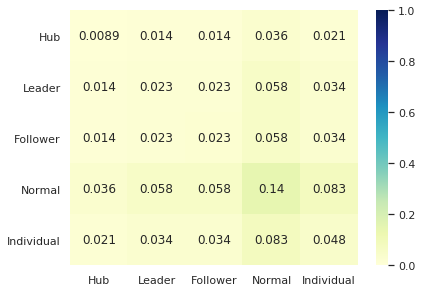

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [125]:
def plot_transition_matrix_heatmap(base_path_artifacts, suffix, df, vmax=4, show=False):
    sns.set(style='white', font_scale = 1, rc={"lines.linewidth": 1})
    
    roles_list = [transle_role(x) for x in range(5)]
    fig, ax = plt.subplots()
    ax = sns.heatmap(pd.DataFrame(df, index=roles_list, columns=roles_list) , annot=True, cmap="YlGnBu", vmin=0, vmax=vmax)
    plt.tight_layout(pad=0.4, w_pad=2, h_pad=1.0)
    fig.savefig(base_path_artifacts + 'transition_matrix_heatmap_' + suffix + '.png')
    plt.savefig(base_path_artifacts + 'transition_matrix_heatmap_.' + suffix + '.eps', format='eps')
    if show:
        plt.show()
    plt.clf()
    plt.close(fig)

def transition_count_matrix(data):
    number_of_states = data.values.max() + 1
    
    M = np.zeros((number_of_states, number_of_states))
    
    for node_idx in range(data.shape[1]):
        for (i,j) in zip(data.iloc[:, node_idx], data.iloc[1:, node_idx]):
            M[i][j] += 1
            
    return M

def convert_role_name_to_role_index(role):
    if (role is 'Hub'):
        return 0
    elif (role is 'Leader'):
        return 1        
    elif (role is 'Follower'):
        return 2
    elif (role is 'Common'):
        return 3
    elif (role is 'Individual'):
        return 4
    else:
        raise 'uknown role'
        
def calc_expected_transition_matrix(state_matrix, roles_prob, cycle_i, cycle_j):
    #calculate the expected transition matrix
    number_of_states = state_matrix.values.max() + 1
    M = np.zeros((number_of_states, number_of_states))
    
    roles_list = [transle_role(x) for x in range(5)]
    
    for row in range(0, M.shape[0]):
        for col in range(0, M.shape[1]):
            M[row, col] = roles_prob.loc[cycle_i, transle_role(row)] * roles_prob.loc[cycle_j, transle_role(col)]
    
    return pd.DataFrame(data=M, index=roles_list, columns=roles_list)

def calc_expected_transition_matrix_based_freq(state_matrix, cycles_upper_bound):
    unique_elements, counts_elements = np.unique(state_matrix.iloc[:cycles_upper_bound].values.flatten(), return_counts=True)
    freq = counts_elements / sum(counts_elements)
    
    number_of_states = state_matrix.values.max() + 1
    M = np.zeros((number_of_states, number_of_states))
    
    roles_list = [transle_role(x) for x in range(5)]
    
    for row in range(0, M.shape[0]):
        for col in range(0, M.shape[1]):
            M[row, col] = freq[row] * freq[col]
    
    return pd.DataFrame(data=M, index=roles_list, columns=roles_list)
    

def plot_roles_transition(base_path_artifacts, analyze_cell_stats_flat, cycles_upper_bound, threshold_i=0.5):    
    state_matrix = analyze_cell_stats_flat.unstack()['Manual_' + str(threshold_i)].transpose()
    
    #calculate the roles prob over cycles
    '''
    roles_prob = pd.DataFrame(columns=['Hub', 'Leader', 'Follower', 'Common', 'Individual']) #columns describes the role
    
    #for cycle in range(0, cycles_upper_bound, 1):
    #    unique_elements, counts_elements = np.unique(state_matrix.iloc[cycle:cycle+1].values.flatten(), return_counts=True)
    #    roles_prob.loc[cycle, :] = counts_elements / sum(counts_elements)
    
    for cycle in range(0, cycles_upper_bound - 1, 1):
        following_cycles_state_matrix = state_matrix.iloc[cycle:cycle + 2, :]
        plot_transition_matrix_heatmap(base_path_artifacts, 'cycles_' + str(cycle) + "_" + str(cycle + 1) + "_counts" , transition_count_matrix(following_cycles_state_matrix), vmax=centroids.shape[0])
        plot_transition_matrix_heatmap(base_path_artifacts, 'cycles_' + str(cycle) + "_" + str(cycle + 1) + "_normalized",transition_matrix(following_cycles_state_matrix), vmax=1)
        
        expected_prob_matrix = calc_expected_transition_matrix(state_matrix, roles_prob, cycle, cycle + 1)
        
        plot_transition_matrix_heatmap(base_path_artifacts, 'cycles_' + str(cycle) + "_" + str(cycle + 1) + "_expected", expected_prob_matrix, vmax=1)
    
        plot_transition_matrix_heatmap(base_path_artifacts, 'cycles_' + str(cycle) + "_" + str(cycle + 1) + "_freq", transition_matrix(following_cycles_state_matrix)/expected_prob_matrix, vmax=50)
    '''
    
    plot_transition_matrix_heatmap(base_path_artifacts, 'cycles_' + str(0) + "_" + str(cycles_upper_bound - 1) + "_counts", transition_count_matrix(state_matrix.iloc[:cycles_upper_bound]), vmax=centroids.shape[0]*4, show=True)
    plot_transition_matrix_heatmap(base_path_artifacts, 'cycles_' + str(0) + "_" + str(cycles_upper_bound - 1) + "_normalized",transition_matrix(state_matrix.iloc[:cycles_upper_bound]), vmax=1, show=True)
    
    expected_prob_matrix = calc_expected_transition_matrix_based_freq(state_matrix, cycles_upper_bound)
    
    plot_transition_matrix_heatmap(base_path_artifacts, 'cycles_' + str(0) + "_" + str(cycles_upper_bound - 1) + "_expected", expected_prob_matrix, vmax=1, show=True)
    
    plot_transition_matrix_heatmap(base_path_artifacts, 'cycles_' + str(0) + "_" + str(cycles_upper_bound - 1) + "_freq", transition_matrix(state_matrix.iloc[:cycles_upper_bound])/expected_prob_matrix, vmax=50, show=True)
    
plot_roles_transition(base_path_artifacts, analyze_cell_stats_flat, cycles_upper_bound=13)

### Check the correlation between the Hub role and the expected

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


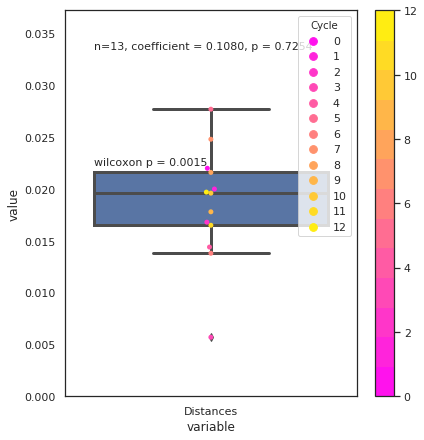

<Figure size 432x288 with 0 Axes>

In [135]:
def plot_roles_dots_over_cycles(base_path_artifacts, analyze_cell_stats_flat, cycles, threshold_i=0.5):
    import scipy.stats as stats
    state_matrix = analyze_cell_stats_flat.unstack()['Manual_' + str(threshold_i)].transpose()

    ## frequency_of_roles
    unique_elements, counts_elements = np.unique(state_matrix.values.flatten(), return_counts=True)
    
    ## Frequency mode during time
    state_matrix_pp = state_matrix.transpose().apply(lambda cell_states:                               
                                   np.bincount(cell_states, minlength=len(unique_elements)), 
                               axis=0)

    state_matrix_pp = state_matrix_pp.round(2).apply(lambda cell_states: distribution_cell_states(cell_states), axis=0).round(2)
    
    state_matrix_pp_t = state_matrix_pp.transpose()
    
    state_matrix_pp_t = state_matrix_pp_t.rename(columns={0: transle_role(0), 
                                                          1: transle_role(1), 
                                                          2: transle_role(2),
                                                          3: transle_role(3),
                                                          4: transle_role(4)})
    
    state_matrix_pp_t['Cycle'] = state_matrix_pp_t.index.astype(int)
    
    #plot roles
    state_matrix_pp_t_melt = pd.melt(state_matrix_pp_t, id_vars=['Cycle'], value_vars=['Hub', 'Individual', 'Follower', 'Leader', 'Common'],
                               var_name='Role', value_name='Portion')
    
    #plot p(leader) * p(follower) vs p(hub)    
    state_matrix_pp_t['P(Leader+Hub)*P(Follower+Hub)'] = (state_matrix_pp_t['Follower'] + state_matrix_pp_t['Hub'])*(state_matrix_pp_t['Leader']+state_matrix_pp_t['Hub'])
    
    state_matrix_pp_t['Distances'] = state_matrix_pp_t['Hub'] - state_matrix_pp_t['P(Leader+Hub)*P(Follower+Hub)']
    
    state_matrix_pp_t = state_matrix_pp_t[state_matrix_pp_t['Cycle'] < cycles]
    
    from scipy.stats import wilcoxon
    
    
    sns.set(style='white', font_scale = 1, rc={"lines.linewidth": 3})
    
    distances_melt = pd.melt(state_matrix_pp_t[['Distances']])
    distances_melt['Cycle'] = distances_melt.index
    
    from matplotlib.colors import ListedColormap
    
    color_pattle = sns.color_palette('spring', state_matrix_pp_t.shape[0])
    my_color_bar = ListedColormap(color_pattle)

    fig, ax = plt.subplots(figsize=(6,6))
    ax = sns.swarmplot(ax=ax, x='variable', y='value', data=distances_melt, hue='Cycle', palette=color_pattle)
    ax = sns.boxplot(ax=ax, x='variable', y='value', data=distances_melt)
    
    #ticks_range = np.arange(0.0, 0.5, step=0.1)
    
    ax.set(ylim=(0.0))
    
    data_correlation = stats.pearsonr(x=state_matrix_pp_t['Cycle'], 
                                  y=state_matrix_pp_t['Distances'])

    ax.annotate("n={}, coefficient = {:.4f}, p = {:.4f}".format(len(state_matrix_pp_t),
                data_correlation[0], data_correlation[1]), 
                xy=(.1, .9), xycoords=ax.transAxes, fontsize=11)
    
    ax.annotate("wilcoxon p = {:.4f}".format(wilcoxon(state_matrix_pp_t['Distances'])[1]),    
                xy=(.1, .6), xycoords=ax.transAxes, fontsize=11)
    
    plt.tight_layout(pad=0.4, w_pad=2, h_pad=1.0)
    
    import matplotlib as mpl
    
    plt.colorbar(mpl.cm.ScalarMappable(cmap=my_color_bar, norm=matplotlib.colors.Normalize(vmin=0, vmax=12)))

    
    fig.savefig(base_path_artifacts + 'roles_leadership_followership_vs_hub_relative_to_expected_box_plot.png')
    plt.savefig(base_path_artifacts + 'roles_leadership_followership_vs_hub_relative_to_expected_box_plot.eps', format='eps')
    plt.show()
    plt.clf()
    plt.close(fig)

#plot_roles_dots_over_cycles(base_path_artifacts, analyze_cell_stats_flat, 13)
plot_roles_dots_over_cycles(base_path_artifacts, analyze_cell_stats_flat, 13)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


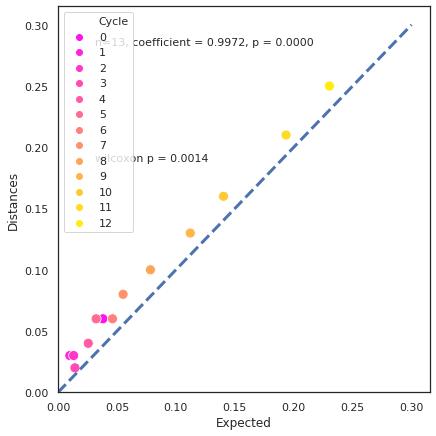

<Figure size 432x288 with 0 Axes>

In [161]:
def rotate(p, origin=(0, 0), degrees=0):
    angle = np.deg2rad(degrees)
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    return np.squeeze((R @ (p.T-o.T) + o.T).T)

def convert_series(y, x):
    rotate_x = np.zeros(len(x))
    rotate_y = np.zeros(len(x))
    
    for idx in range(0, len(x)):
        rotate_y[idx], rotate_x[idx] = rotate((y[idx], x[idx]), degrees=45)
    
    return rotate_y, rotate_x

def plot_roles_dots_over_cycles(base_path_artifacts, analyze_cell_stats_flat, cycles, threshold_i=0.5):
    import scipy.stats as stats
    state_matrix = analyze_cell_stats_flat.unstack()['Manual_' + str(threshold_i)].transpose()

    ## frequency_of_roles
    unique_elements, counts_elements = np.unique(state_matrix.values.flatten(), return_counts=True)
    
    ## Frequency mode during time
    state_matrix_pp = state_matrix.transpose().apply(lambda cell_states:                               
                                   np.bincount(cell_states, minlength=len(unique_elements)), 
                               axis=0)

    state_matrix_pp = state_matrix_pp.round(2).apply(lambda cell_states: distribution_cell_states(cell_states), axis=0).round(2)
    
    state_matrix_pp_t = state_matrix_pp.transpose()
    
    state_matrix_pp_t = state_matrix_pp_t.rename(columns={0: transle_role(0), 
                                                          1: transle_role(1), 
                                                          2: transle_role(2),
                                                          3: transle_role(3),
                                                          4: transle_role(4)})
    
    state_matrix_pp_t['Cycle'] = state_matrix_pp_t.index.astype(int)
    
    #plot roles
    state_matrix_pp_t_melt = pd.melt(state_matrix_pp_t, id_vars=['Cycle'], value_vars=['Hub', 'Individual', 'Follower', 'Leader', 'Common'],
                               var_name='Role', value_name='Portion')
    
    #plot p(leader) * p(follower) vs p(hub)    
    state_matrix_pp_t['P(Leader+Hub)*P(Follower+Hub)'] = (state_matrix_pp_t['Follower'] + state_matrix_pp_t['Hub'])*(state_matrix_pp_t['Leader']+state_matrix_pp_t['Hub'])
    
    state_matrix_pp_t['Distances'], state_matrix_pp_t['Expected'] = state_matrix_pp_t['Hub'], state_matrix_pp_t['P(Leader+Hub)*P(Follower+Hub)']
    
    state_matrix_pp_t = state_matrix_pp_t[state_matrix_pp_t['Cycle'] < cycles]
    
    from scipy.stats import wilcoxon
    
    
    sns.set(style='white', font_scale = 1, rc={"lines.linewidth": 3})

    fig, ax = plt.subplots(figsize=(6,6))
    ax = sns.scatterplot(ax=ax, x='Expected', y='Distances', hue='Cycle', data=state_matrix_pp_t, s=100, palette=sns.color_palette('spring', state_matrix_pp_t.shape[0]))
    
    #ticks_range = np.arange(0.0, 0.5, step=0.1)
    
    #ax.set(xlim=(0.0, 0.4), ylim=(0.0, 0.4), xticks=ticks_range, yticks=ticks_range)
    
    data_correlation = stats.pearsonr(x=state_matrix_pp_t['Expected'], 
                                  y=state_matrix_pp_t['Distances'])
    
    plt.plot(np.arange(0.0, 0.4, step=0.1), np.arange(0.0, 0.4, step=0.1), linestyle='--')

    ax.annotate("n={}, coefficient = {:.4f}, p = {:.4f}".format(len(state_matrix_pp_t),
                data_correlation[0], data_correlation[1]), 
                xy=(.1, .9), xycoords=ax.transAxes, fontsize=11)
    
    ax.annotate("wilcoxon p = {:.4f}".format(wilcoxon(state_matrix_pp_t['Distances'])[1]),      
                xy=(.1, .6), xycoords=ax.transAxes, fontsize=11)
    
    ax.set(xlim=(0.0), ylim=(0.0))
    
    plt.tight_layout(pad=0.4, w_pad=2, h_pad=1.0)

    
    fig.savefig(base_path_artifacts + 'roles_leadership_followership_vs_hub_relative_to_expected.png')
    plt.savefig(base_path_artifacts + 'roles_leadership_followership_vs_hub_relative_to_expected.eps', format='eps')
    plt.show()
    plt.clf()
    plt.close(fig)

#plot_roles_dots_over_cycles(base_path_artifacts, analyze_cell_stats_flat, 13)
plot_roles_dots_over_cycles(base_path_artifacts, analyze_cell_stats_flat, 13)

### Movie - Hubs role proprgation through cycles.

In [ ]:
import random
import pylab
from matplotlib.pyplot import pause
import networkx as nx
from matplotlib import animation, rc
from IPython.display import HTML
from plots_analyzetools import plot_voronoi, plot_colormap
import matplotlib as mpl

def create_hub_color_mapper(cmap, max_cycles):
    cnorm =  mpl.colors.PowerNorm(gamma=1./2., vmin=0, vmax=max_cycles)
    mapper = mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap)
    
    return mapper

def make_role_movie(analyze_cell_stats_flat, role_index, metric_name, base_path_artifacts, colormap=mpl.cm.Blues, threshold_i=0.5):
    max_cycles = (len(list(indexes)) - 2)
    # Build plot
    fig, axs = plt.subplots(figsize=(12,10), nrows=1, ncols=1)
    
    cells_roles = analyze_cell_stats_flat.unstack()['Manual_' + str(threshold_i)]
    plt.suptitle('Cells Maintain Memory of their Functional\n in Cell-Cell Communication')
    plt.subplots_adjust(top=0.80)
    mapper = create_hub_color_mapper(colormap, max_cycles)
    plot_colormap(mapper)
    date_index2 = range(1, len(centroids) + 1)
    cells_roles = cells_roles.reindex(date_index2, fill_value = -1)
    print('max cycle index:' + str(max_cycles))
    
    def init():
        #do nothing
        pass

    def update(part):       
        
        cells_roles.iloc[:, part] = np.where(cells_roles.iloc[:, part] == role_index, 1, 0)
        
        if part > 0:
            cells_roles.iloc[:, part] = cells_roles.iloc[:, part - 1] + cells_roles.iloc[:, part]
        
        data = cells_roles.iloc[:, part]
        data = data.values
        
        #data = apply_custom_filter(data, kpss_and_adf_filter)
        #custom_filter = np.greater(data, np.zeros((len(data))))
        custom_filter = data != 0
        
        axs.set_facecolor('w')
        
        plot_voronoi(axs, mapper, regions, vertices, vor, centroids, 
                         data,
                         custom_filter)

        # Scale plot ax
        axs.set_title(metric_name + " Cycle %d"%(part), fontweight="bold")
        axs.set_xticks([])
        axs.set_yticks([])
        
        #plot_correlation(axs[0], part)

    anim = animation.FuncAnimation(fig, update, frames=max_cycles, interval=500, repeat=True, init_func=init)
    
    anim.save(base_path_artifacts + metric_name + '_cells_memory.mp4')

    return None #HTML(anim.to_html5_video())

def plot_hub_movies(analyze_cell_stats_flat, base_path_artifacts):
    sns.set(style='white', font_scale = 2, rc={"lines.linewidth": 4})

    make_role_movie(analyze_cell_stats_flat, 0, 'Cumulative Hub Count', base_path_artifacts)
    
    make_role_movie(analyze_cell_stats_flat, 1, 'Cumulative Individual Count', base_path_artifacts)
    
    make_role_movie(analyze_cell_stats_flat, 2, 'Cumulative Follower Count', base_path_artifacts)
    
    make_role_movie(analyze_cell_stats_flat, 3, 'Cumulative Leader Count', base_path_artifacts)
    
    make_role_movie(analyze_cell_stats_flat, 4, 'Cumulative Normal Count', base_path_artifacts)

    sns.set()

movie1 = plot_hub_movies(analyze_cell_stats_flat, base_path_artifacts)

In [ ]:
import random
import pylab
from matplotlib.pyplot import pause
import networkx as nx
from matplotlib import animation, rc
from IPython.display import HTML
from plots_analyzetools import plot_voronoi, plot_colormap
import matplotlib as mpl

def create_hub_color_mapper(cmap):
    cnorm =  mpl.colors.PowerNorm(gamma=1./2., vmin=0, vmax=1)
    mapper = mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap)
    
    return mapper

def make_role_movie(analyze_cell_stats_flat, role_index, metric_name, base_path_artifacts, colormap=mpl.cm.Blues, threshold_i=0.5):
    max_cycles = (len(list(indexes)) - 2)
    # Build plot
    fig, axs = plt.subplots(figsize=(12,10), nrows=1, ncols=1)
    
    cells_roles = analyze_cell_stats_flat.unstack()['Manual_' + str(threshold_i)]
    plt.suptitle('Cells Maintain Memory of their Functional\n in Cell-Cell Communication')
    plt.subplots_adjust(top=0.80)
    mapper = create_hub_color_mapper(colormap)
    plot_colormap(mapper)
    date_index2 = range(1, len(centroids) + 1)
    cells_roles = cells_roles.reindex(date_index2, fill_value = -1)
    print('max cycle index:' + str(max_cycles))
    
    def init():
        #do nothing
        pass

    def update(part):    
        
        cells_roles.iloc[:, part] = np.where(cells_roles.iloc[:, part] == role_index, 1, 0)
        
        if part > 0:
            cells_roles.iloc[:, part] = cells_roles.iloc[:, part - 1] + cells_roles.iloc[:, part]
        
        data = cells_roles.iloc[:, part]
        data = data.values / (part + 1)
        
        #data = apply_custom_filter(data, kpss_and_adf_filter)
        #custom_filter = np.greater(data, np.zeros((len(data))))
        custom_filter = data != 0
        
        axs.set_facecolor('w')
        
        plot_voronoi(axs, mapper, regions, vertices, vor, centroids, 
                         data,
                         custom_filter)

        # Scale plot ax
        axs.set_title(metric_name + " Cycle %d"%(part), fontweight="bold")
        axs.set_xticks([])
        axs.set_yticks([])
        
        #plot_correlation(axs[0], part)

    anim = animation.FuncAnimation(fig, update, frames=max_cycles, interval=500, repeat=True, init_func=init)
    
    anim.save(base_path_artifacts + metric_name + '_cells_memory.mp4')

    return None #HTML(anim.to_html5_video())

def plot_hub_movies(analyze_cell_stats_flat, base_path_artifacts):
    sns.set(style='white', font_scale = 2, rc={"lines.linewidth": 4})

    make_role_movie(analyze_cell_stats_flat, 0, 'Cumulative Hub Count divide by Cycle', base_path_artifacts)
    
    make_role_movie(analyze_cell_stats_flat, 1, 'Cumulative Individual Count by Cycle', base_path_artifacts)
    
    make_role_movie(analyze_cell_stats_flat, 2, 'Cumulative Follower Count by Cycle', base_path_artifacts)
    
    make_role_movie(analyze_cell_stats_flat, 3, 'Cumulative Leader Count by Cycle', base_path_artifacts)
    
    make_role_movie(analyze_cell_stats_flat, 4, 'Cumulative Normal Count by Cycle', base_path_artifacts)

    sns.set()

movie1 = plot_hub_movies(analyze_cell_stats_flat, base_path_artifacts)